In [1]:
# Random Forest Classification Script for Mice Protein Expression Dataset
# Implements data exploration, preprocessing, hyperparameter tuning, and evaluation
# Includes outlier handling, feature importance, holdout vs. CV comparison, parameter sensitivity,
# preprocessing strategy comparison, runtime analysis, report-ready summaries, and trend identification

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import time
import os
%matplotlib inline

In [ ]:
# Cell 1: Data Exploration
def detect_outliers(df, numerical_cols):
    """Detect and visualize outliers using IQR method for numerical features."""
    print("\nOutlier Analysis:")
    outlier_counts = {}
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_counts[col] = len(outliers)
        if len(outliers) > 0:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            plt.savefig(f'outliers_{col}_mice.png')
            plt.close()
    print("\nSummary of Outliers:", pd.Series(outlier_counts))

def explore_dataset(df):
    """Explore dataset structure, class distribution, missing values, outliers, and correlations."""
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 Rows:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    
    # Class distribution
    class_counts = df['class'].value_counts()
    print("\nClass Distribution:\n", class_counts)
    print("\nClass Names:", class_counts.index.tolist())
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.savefig('class_distribution_mice.png')
    plt.close()
    
    # Missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values[missing_values > 0])
    
    # Feature statistics
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    print("\nFeature Statistics:\n", df[numerical_cols].describe())
    
    # Feature correlations (subset of features)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols[:20]].corr(), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap (First 20 Features)')
    plt.savefig('feature_correlation_mice.png')
    plt.close()
    
    # Out fire detection
    detect_outliers(df, numerical_cols)

# Load dataset from local file with error handling
data_file = 'Data_Cortex_Nuclear.xls'  
try:
    df = pd.read_excel(data_file)
    if 'class' not in df.columns:
        raise ValueError("Dataset must contain 'class' column")
except Exception as e:
    print(f"Error loading local data file: {e}")
    print(f"Please ensure '{data_file}' exists in the correct directory.")
    exit(1)

# Verify dataset
print("\nVerifying Dataset:")
print(f"Expected Samples: 1080, Actual Samples: {df.shape[0]}")
expected_classes = ['c-CS-s', 'c-CS-m', 'c-SC-s', 'c-SC-m', 't-CS-s', 't-CS-m', 't-SC-s', 't-SC-m']
actual_classes = df['class'].unique()
print(f"Expected Classes: {expected_classes}")
print(f"Actual Classes: {actual_classes.tolist()}")

# Explore dataset
explore_dataset(df)


Verifying Dataset:
Expected Samples: 1080, Actual Samples: 1080
Expected Classes: ['c-CS-s', 'c-CS-m', 'c-SC-s', 'c-SC-m', 't-CS-s', 't-CS-m', 't-SC-s', 't-SC-m']
Actual Classes: ['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s', 't-CS-m', 't-SC-m', 't-CS-s', 't-SC-s']

Dataset Shape: (1080, 82)

First 5 Rows:
   MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0   309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1   309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2   309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3   309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4   309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   

    pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0  0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1  0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2  0.175722   2.283337  0.230247  ...  0.

In [3]:
# Cell 3: Preprocessing
def preprocess_data(df, scaling=True, imputation_strategy='mean', sample_fraction=1.0, include_categorical=False):
    """Preprocess the dataset: sample, impute missing values, encode features, scale, split data.
    Args:
        df: Input DataFrame
        scaling: Whether to apply StandardScaler (True) or not (False)
        imputation_strategy: Strategy for numerical imputation ('mean' or 'median')
        sample_fraction: Fraction of data to sample (e.g., 0.5 for 50%)
        include_categorical: Whether to include Genotype, Treatment, Behavior (True) or not (False)
    Returns:
        X_train, X_test, y_train, y_test, le, feature_cols
    """
    # Subsample dataset
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    
    # Define feature columns
    exclude_cols = ['MouseID', 'class']
    if not include_categorical:
        exclude_cols.extend(['Genotype', 'Treatment', 'Behavior'])
    feature_cols = [col for col in sampled_df.columns if col not in exclude_cols]
    X = sampled_df[feature_cols]
    y = sampled_df['class']
    
    # Handle categorical features if included
    categorical_cols = X.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Impute missing values with specified strategy
    imputer = SimpleImputer(strategy=imputation_strategy)
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print("\nMissing values after imputation:", X_imputed.isnull().sum().sum())
    
    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print("\nClasses:", le.classes_)
    
    # Scale features if specified
    if scaling:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X_imputed)
    else:
        X_processed = X_imputed.values
    
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print(f"\nDataset size: {sampled_df.shape[0]}, Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test, le, feature_cols

In [ ]:
# Cell 4: Random Forest Experiments
def run_rf_experiments(X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Run Random Forest experiments with different parameter settings."""
    # Define parameter grid with more variation
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],  # Added variation
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2]
    }
    
    results = []
    print("\n=== Random Forest Experiments ===")
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        print(f"\nTesting: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}, min_samples_leaf={min_samples_leaf}")
                        rf_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42,
                            class_weight='balanced'
                        )
                        start_time = time.time()
                        rf_classifier.fit(X_train, y_train)
                        training_time = time.time() - start_time
                        start_time = time.time()
                        predictions = rf_classifier.predict(X_test)
                        prediction_time = time.time() - start_time
                        accuracy = accuracy_score(y_test, predictions)
                        f1 = f1_score(y_test, predictions, average='weighted')
                        roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
                        cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=3, scoring='accuracy')
                        cv_accuracy = np.mean(cv_scores)
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features,
                            'min_samples_leaf': min_samples_leaf,
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'cv_accuracy': cv_accuracy,
                            'training_time': training_time,
                            'prediction_time': prediction_time
                        })
                        print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}, CV Accuracy: {cv_accuracy:.2f}")
                        print(f"Training Time: {training_time:.2f}s, Prediction Time: {prediction_time:.2f}s")
    
    return results

# Cell 5: Visualization and Analysis
def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Visualize results, save to CSV, and generate report-ready summaries."""
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:\n", results_df)
    
    # Ensure correct data types for plotting
    results_df['n_estimators'] = results_df['n_estimators'].astype(int)
    results_df['max_depth'] = results_df['max_depth'].astype(str)  
    results_df['min_samples_split'] = results_df['min_samples_split'].astype(int)
    results_df['max_features'] = results_df['max_features'].astype(str)
    results_df['min_samples_leaf'] = results_df['min_samples_leaf'].astype(int)
    
    summarize_best_models(results_df)
    compare_holdout_cv(results_df)
    analyze_parameter_sensitivity(results_df)
    identify_trends(results_df)
    
    results_df.to_csv("rf_results_mice.csv", index=False)
    
    best_idx = results_df['accuracy'].idxmax()
    max_depth = results_df.loc[best_idx]['max_depth']
    max_depth = None if max_depth == 'None' else int(max_depth)
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    plot_feature_importance(best_rf, feature_cols)
    
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_mice.png')
    plt.show()
    
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_mice.png')
    plt.show()
    
    # Plot accuracy vs. max_depth (only if max_depth has variation)
    if len(results_df['max_depth'].unique()) > 1:
        plt.figure(figsize=(8, 6))
        sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
        plt.title('Accuracy vs. max_depth')
        plt.savefig('rf_accuracy_vs_max_depth_mice.png')
        plt.show()
    else:
        print("Skipping 'Accuracy vs. max_depth' plot: max_depth has no variation.")
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_mice.png')
    plt.show()

In [5]:
# Cell 5: Visualization and Analysis
def plot_feature_importance(model, feature_cols):
    """Plot feature importances of the Random Forest model."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]  # Top 20 features for readability
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_cols[i] for i in indices], rotation=45)
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('rf_feature_importance_mice.png')
    plt.show()

def compare_holdout_cv(results_df):
    """Compare holdout and cross-validation accuracies."""
    results_df['holdout_cv_diff'] = results_df['accuracy'] - results_df['cv_accuracy']
    print("\nHoldout vs. CV Accuracy Difference:\n", results_df[['accuracy', 'cv_accuracy', 'holdout_cv_diff']].describe())
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=results_df, x='cv_accuracy', y='accuracy', hue='n_estimators')
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('Holdout vs. Cross-Validation Accuracy')
    plt.savefig('rf_holdout_vs_cv_mice.png')
    plt.show()

def analyze_parameter_sensitivity(results_df):
    """Analyze sensitivity of accuracy to parameter settings."""
    print("\nParameter Sensitivity (Std of Accuracy):")
    for param in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf']:
        grouped = results_df.groupby(param)['accuracy'].std()
        print(f"{param}:\n{grouped}")

def summarize_best_models(results_df, top_n=5):
    """Summarize top N models by accuracy."""
    top_models = results_df.nlargest(top_n, 'accuracy')[['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf', 'accuracy', 'f1_score', 'roc_auc', 'cv_accuracy', 'training_time']]
    print("\nTop 5 Models:\n", top_models)
    top_models.to_csv('rf_top_models_mice.csv', index=False)

def identify_trends(results_df):
    """Identify common parameter values in top 10 models."""
    print("\nMost Common Parameters in Top 10 Models:")
    top_10 = results_df.nlargest(10, 'accuracy')
    for param in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf']:
        print(f"{param}: {top_10[param].value_counts().head(1)}")

def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Visualize results, save to CSV, and generate report-ready summaries.
    Includes confusion matrix, classification report, parameter sensitivity, and feature importance.
    """
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:\n", results_df)
    
    # Additional analyses
    summarize_best_models(results_df)
    compare_holdout_cv(results_df)
    analyze_parameter_sensitivity(results_df)
    identify_trends(results_df)
    
    # Save results
    results_df.to_csv("rf_results_mice.csv", index=False)
    
    # Find best model
    best_idx = results_df['accuracy'].idxmax()
    max_depth = results_df.loc[best_idx]['max_depth']
    max_depth = None if pd.isna(max_depth) else int(max_depth)
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    # Feature importance
    plot_feature_importance(best_rf, feature_cols)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_mice.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_mice.png')
    plt.show()
    
    # Plot accuracy vs. max_depth
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
    plt.title('Accuracy vs. max_depth')
    plt.savefig('rf_accuracy_vs_max_depth_mice.png')
    plt.show()
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_mice.png')
    plt.show()


=== Experiments: Scaling=True, Imputation=mean, Fraction=0.5, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.92, F1-Score: 0.92, ROC-AUC: 1.00, CV Accuracy: 0.92
Training Time: 0.28s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.95, F1-Score: 0.95, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.42s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.94, F1-Score: 0.94, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.25s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split

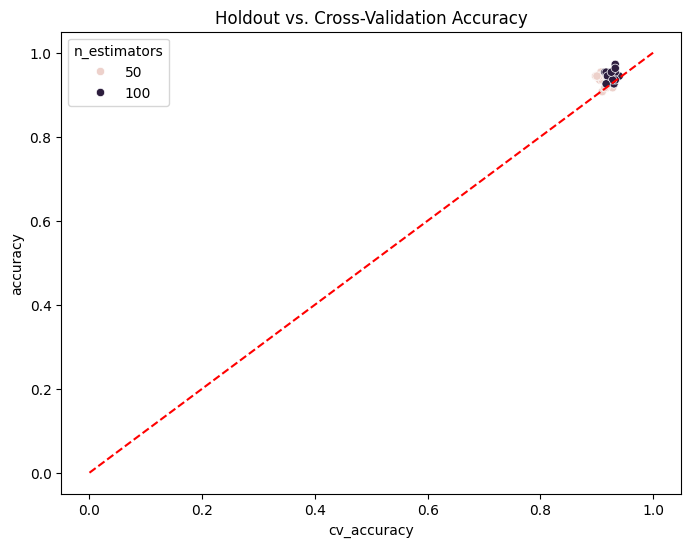


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.014955
100    0.012782
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.011651
20.0    0.015677
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.014783
5    0.013782
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.015120
sqrt    0.014426
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.015798
2    0.013370
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    7
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
5    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


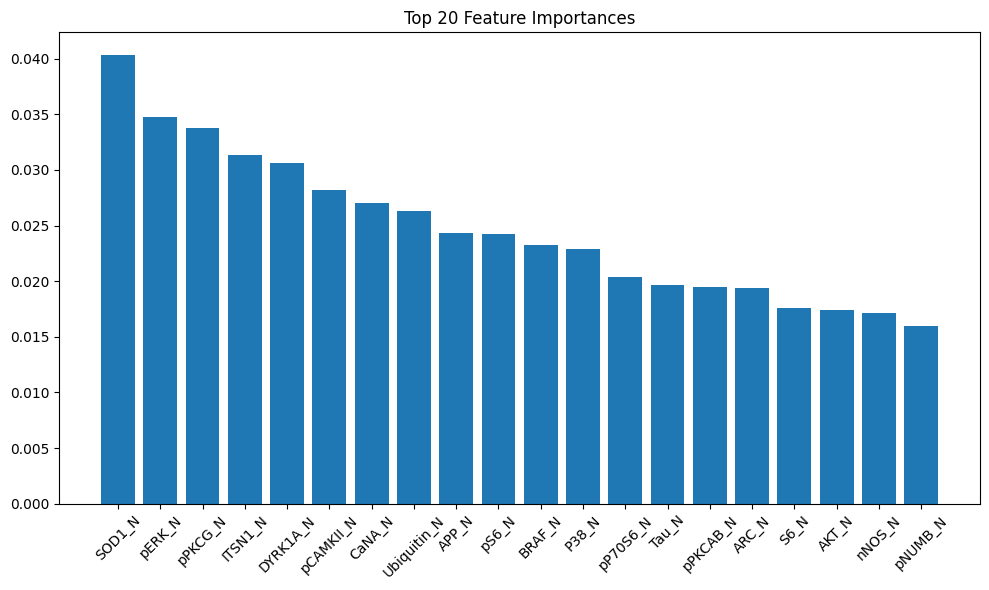

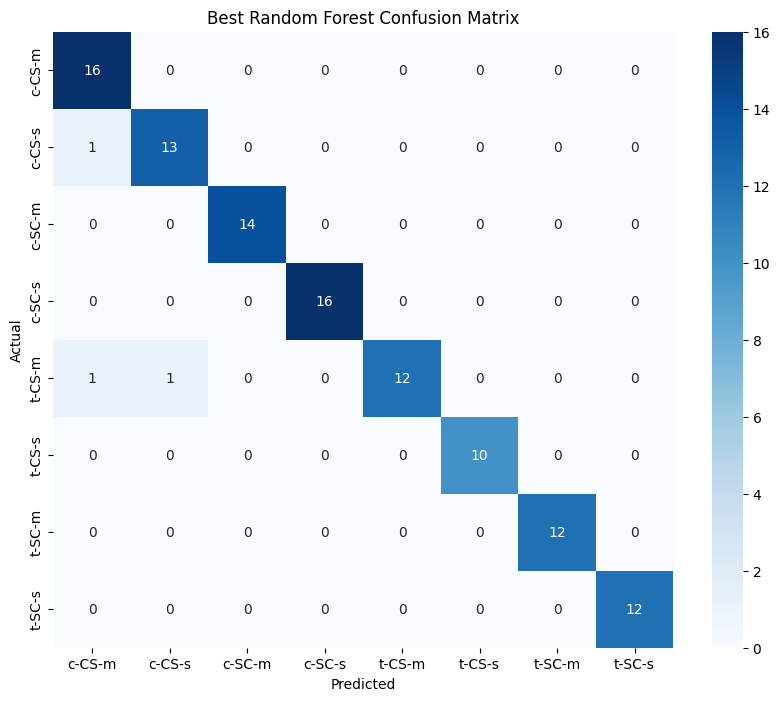


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       0.89      1.00      0.94        16
      c-CS-s       0.93      0.93      0.93        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      1.00      1.00        16
      t-CS-m       1.00      0.86      0.92        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       1.00      1.00      1.00        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           0.97       108
   macro avg       0.98      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108



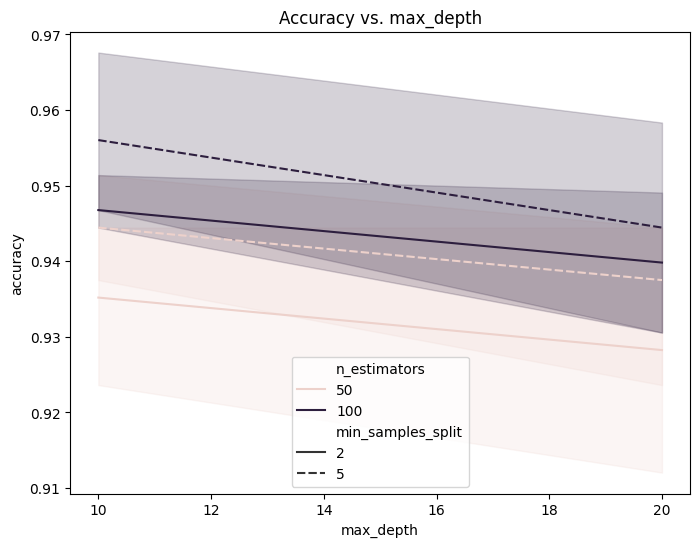

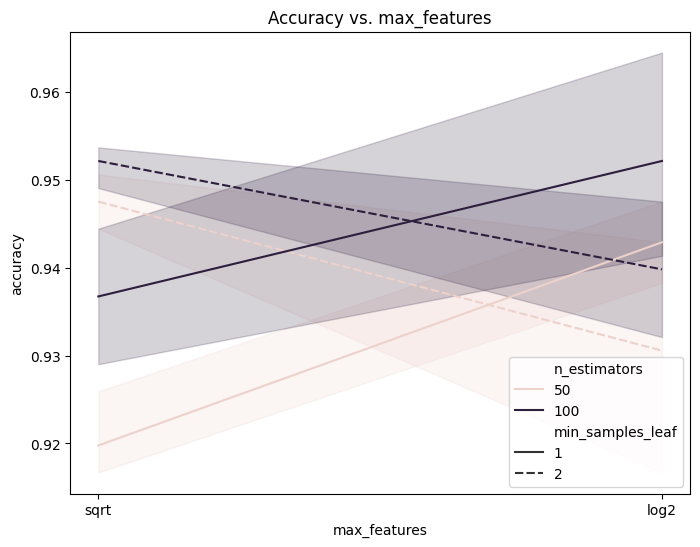


=== Experiments: Scaling=True, Imputation=mean, Fraction=0.5, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.29s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.41s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.28s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.25s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 1.08s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None,

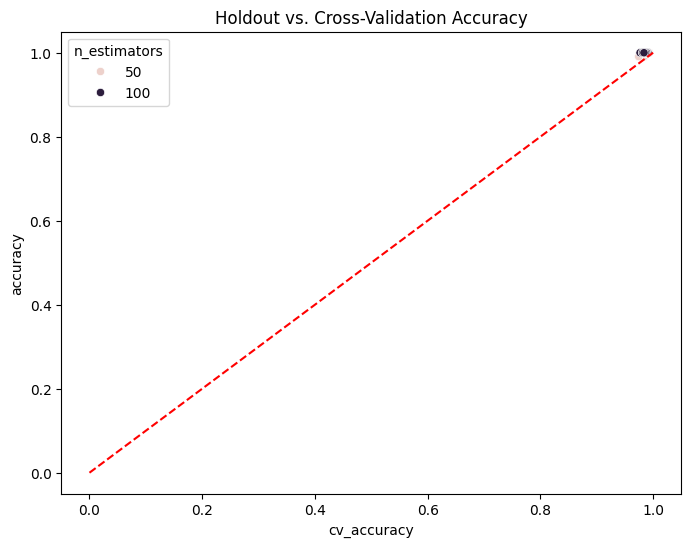


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.003841
100    0.000000
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.002315
20.0    0.003163
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.003841
5    0.000000
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.003841
sqrt    0.000000
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.002614
2    0.003128
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    5
Name: count, dtype: int64
max_features: max_features
sqrt    7
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    6
Name: count, dtype: int64


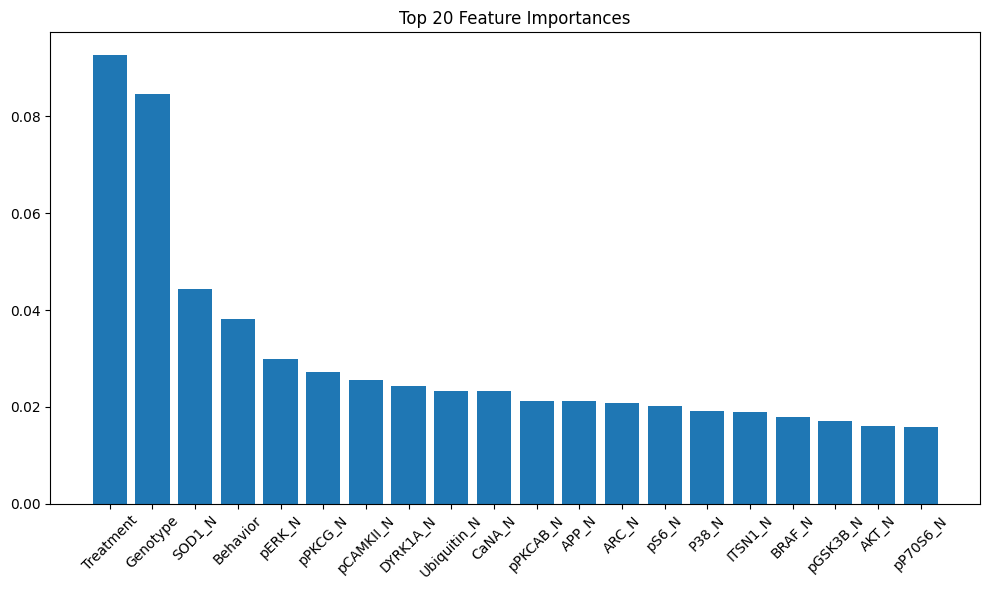

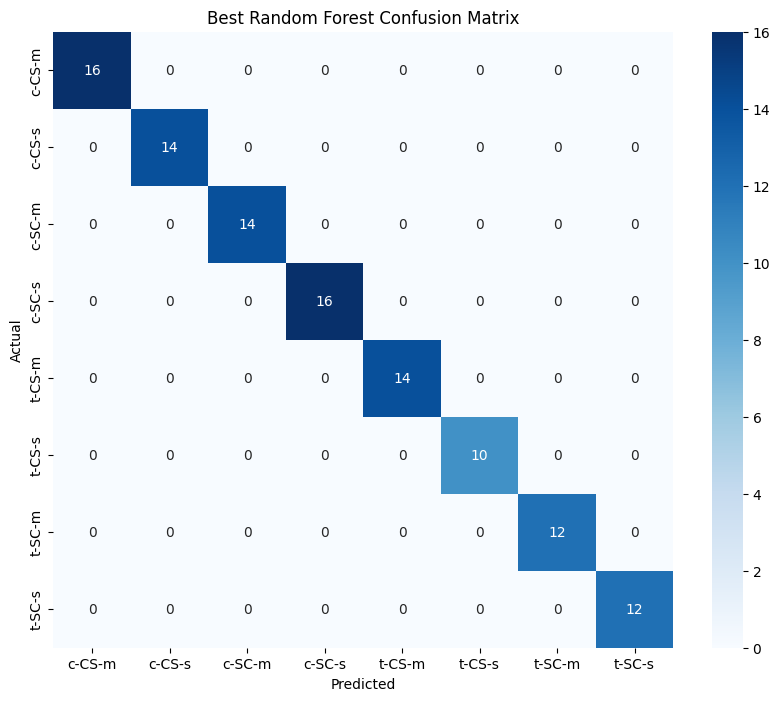


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        16
      c-CS-s       1.00      1.00      1.00        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      1.00      1.00        16
      t-CS-m       1.00      1.00      1.00        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       1.00      1.00      1.00        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



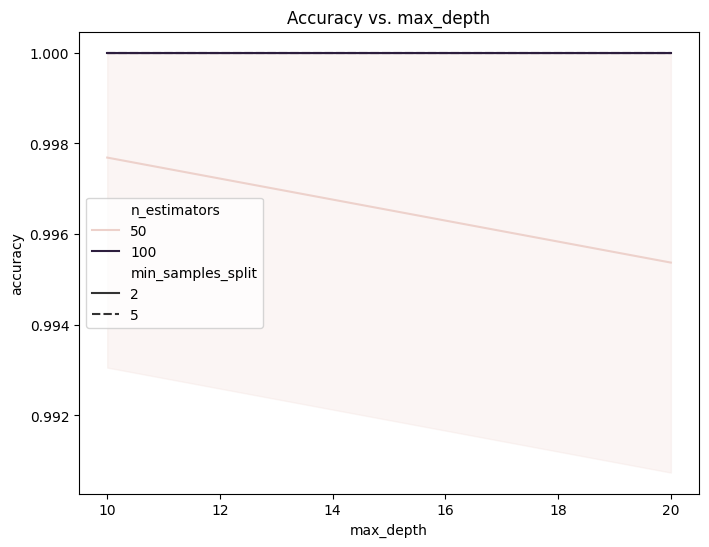

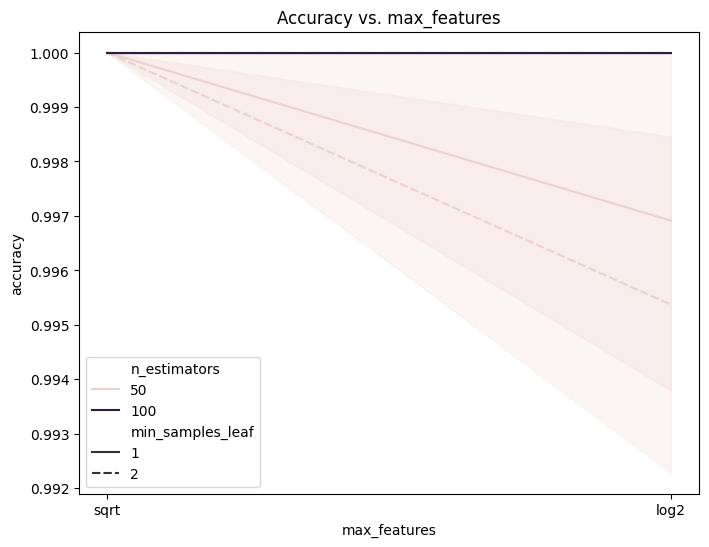


=== Experiments: Scaling=True, Imputation=mean, Fraction=1.0, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.53s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.96
Training Time: 0.50s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.53s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_spli

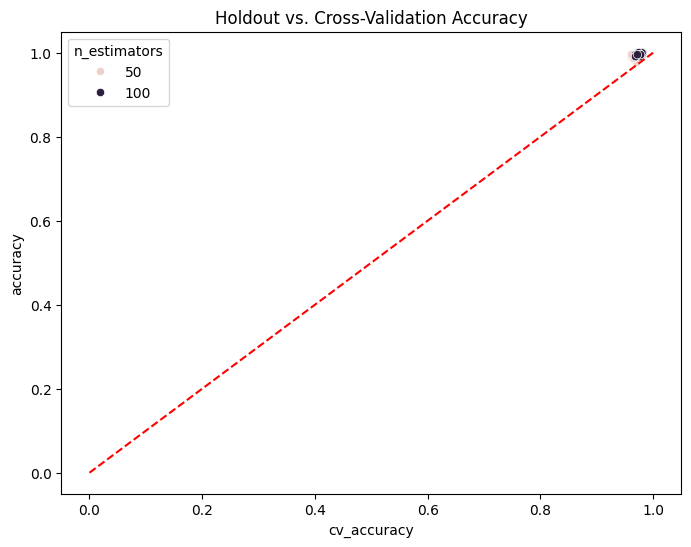


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.006355
100    0.003590
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.007147
20.0    0.004098
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.004981
5    0.005254
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.002365
sqrt    0.005670
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.003734
2    0.005789
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    7
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    8
Name: count, dtype: int64
max_features: max_features
log2    8
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    8
Name: count, dtype: int64


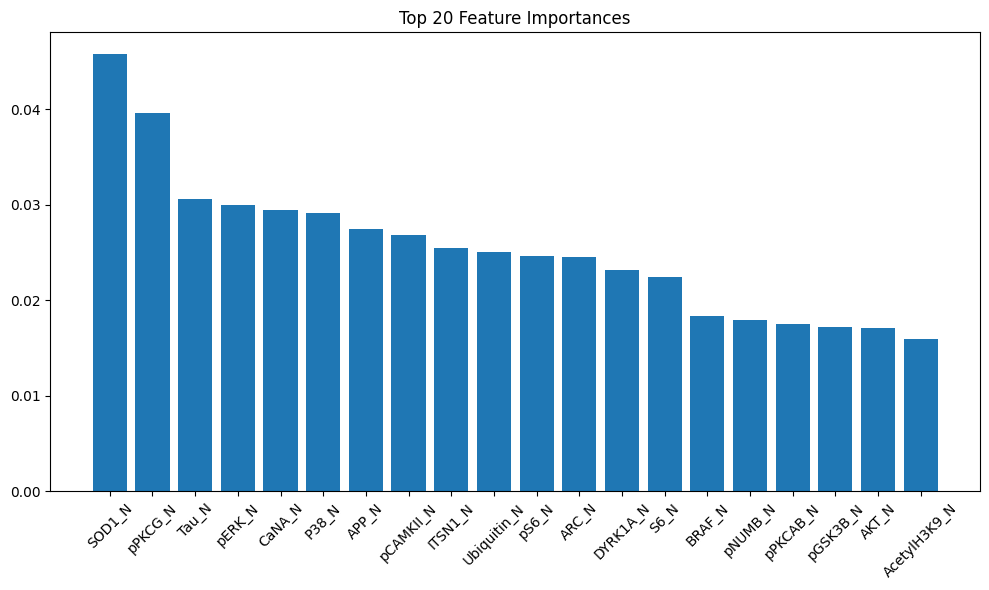

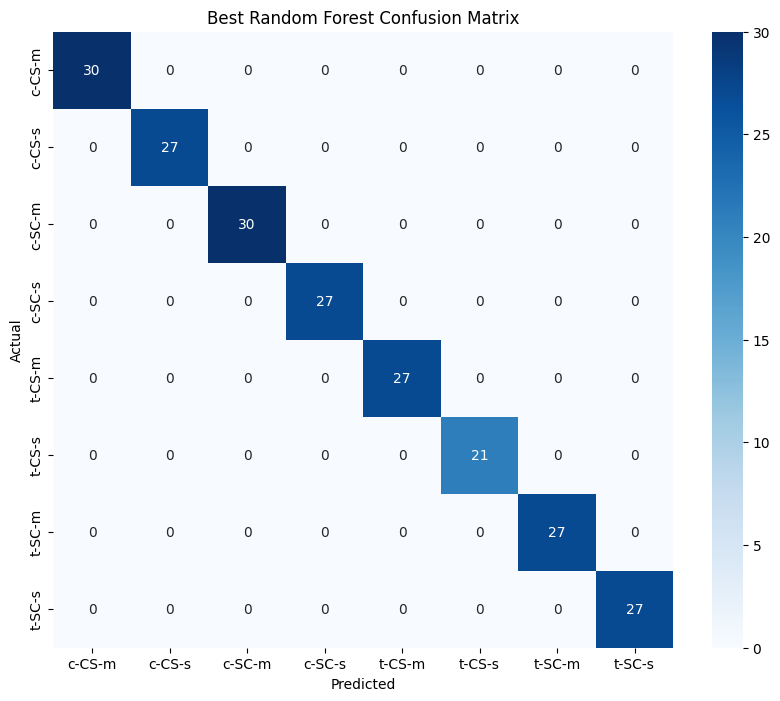


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



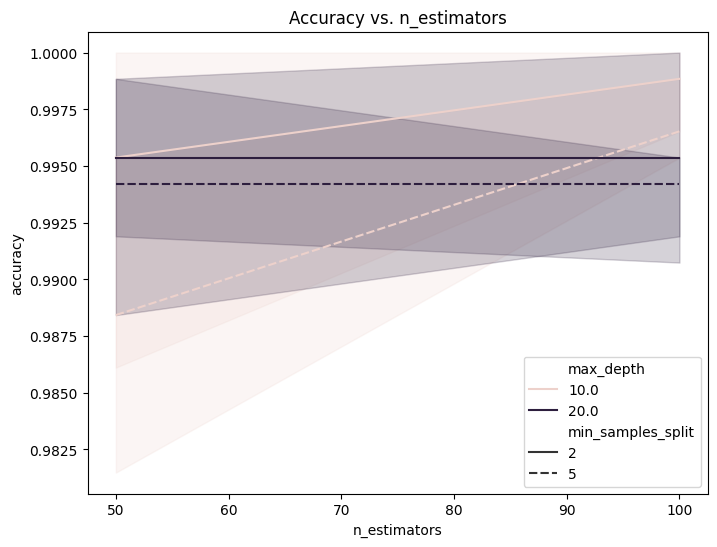

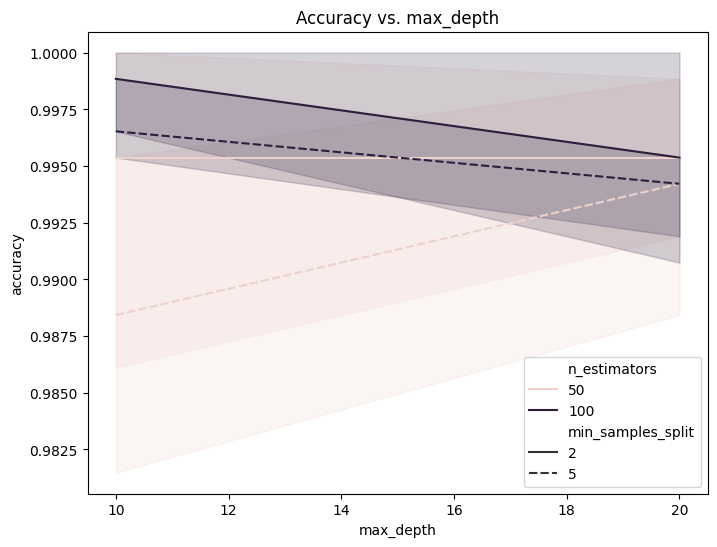

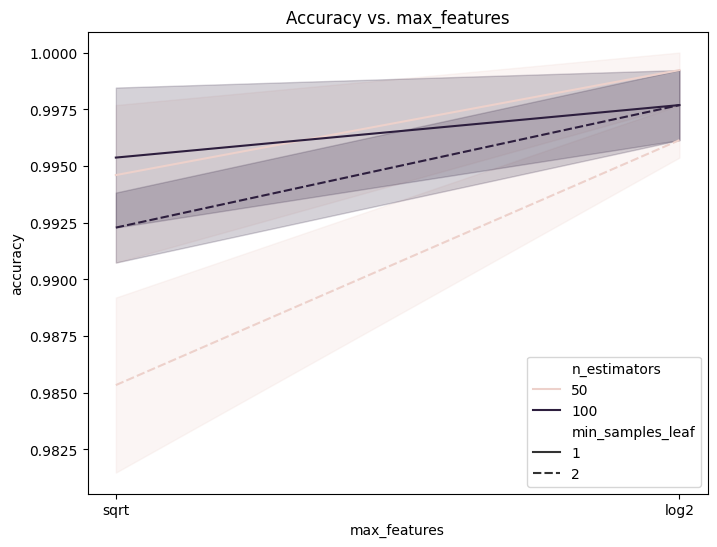


=== Experiments: Scaling=True, Imputation=mean, Fraction=1.0, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.57s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.37s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.57s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.48s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.66s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None,

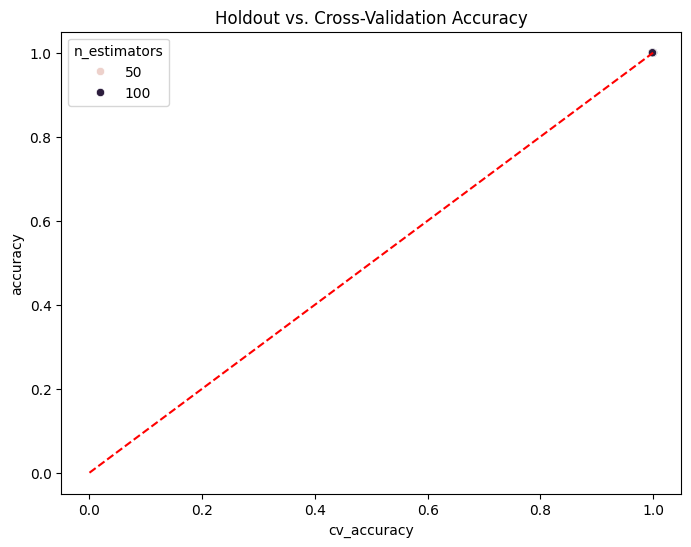


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.0
100    0.0
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.0
20.0    0.0
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.0
5    0.0
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.0
sqrt    0.0
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.0
2    0.0
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


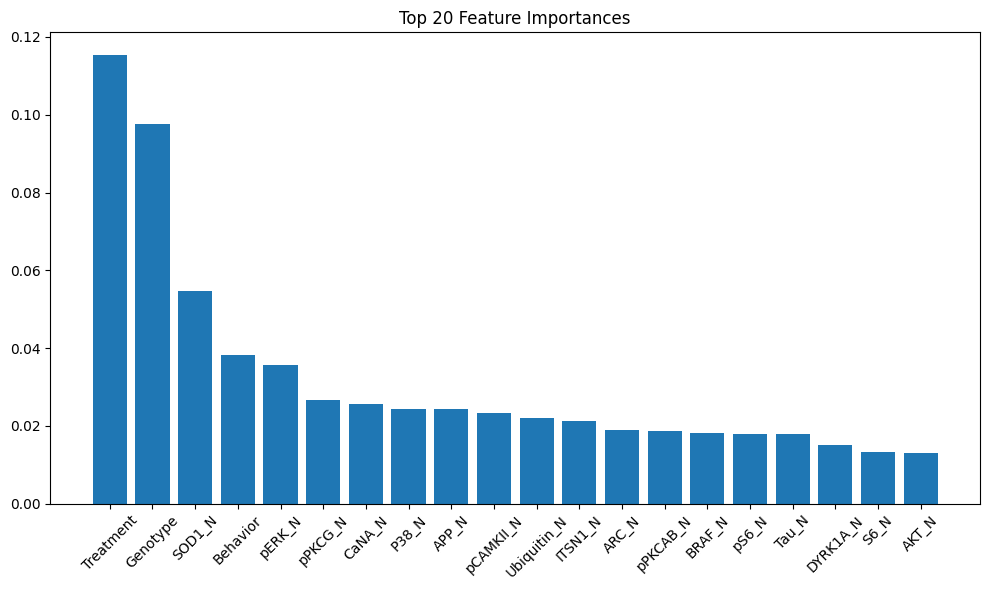

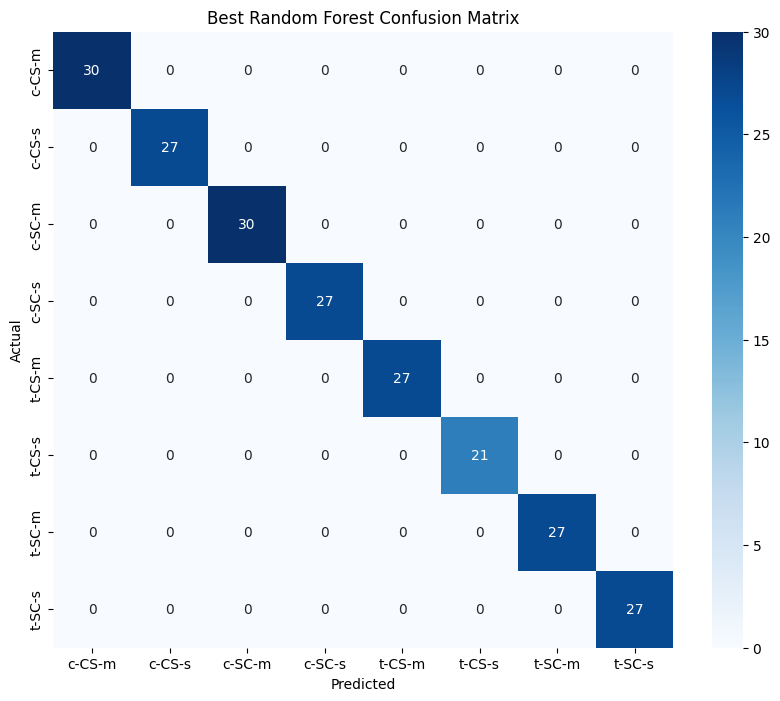


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



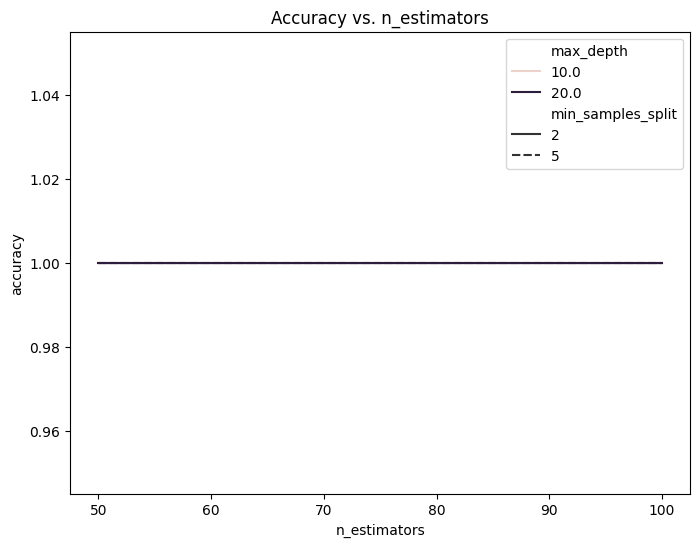

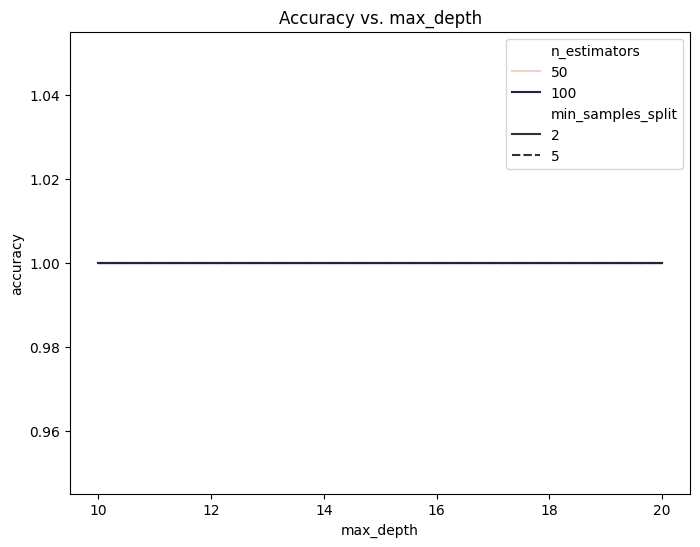

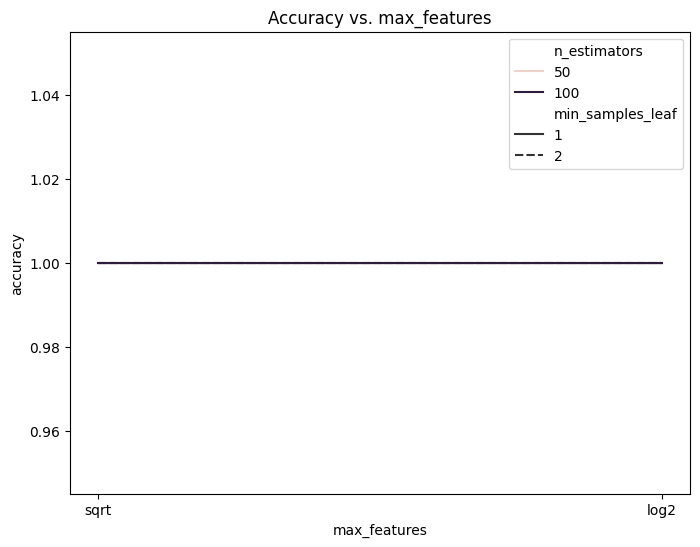


=== Experiments: Scaling=True, Imputation=median, Fraction=0.5, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.94, F1-Score: 0.94, ROC-AUC: 1.00, CV Accuracy: 0.92
Training Time: 0.32s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.95, F1-Score: 0.95, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.55s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.94, F1-Score: 0.94, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.52s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_spl

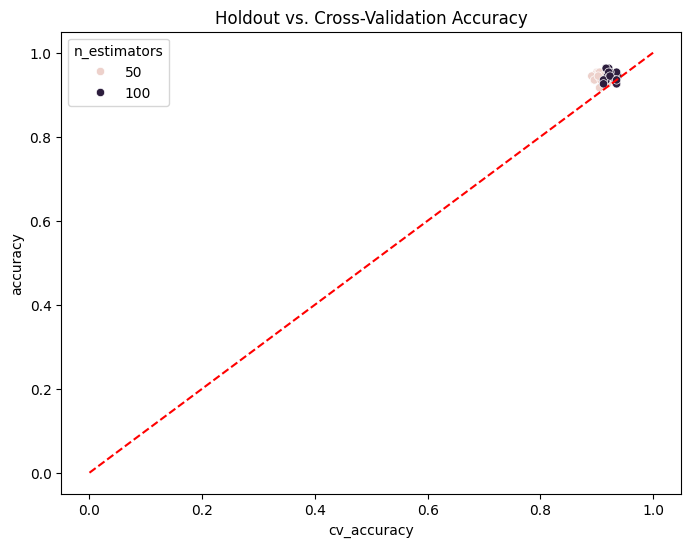


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.009837
100    0.012109
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.011324
20.0    0.011150
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.009645
5    0.009426
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.008839
sqrt    0.012999
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.009021
2    0.012356
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    5
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    9
Name: count, dtype: int64
max_features: max_features
sqrt    7
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
2    8
Name: count, dtype: int64


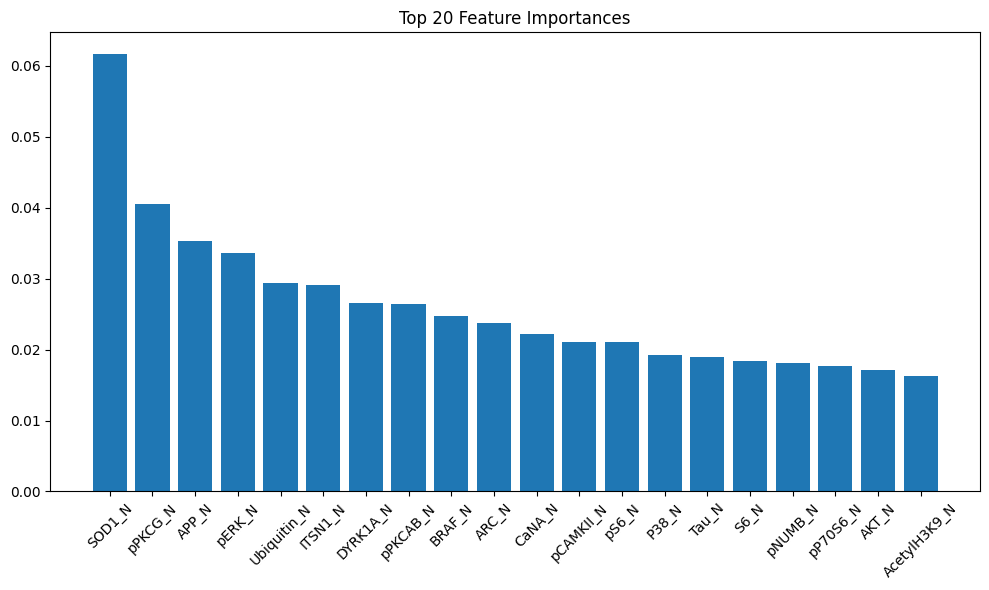

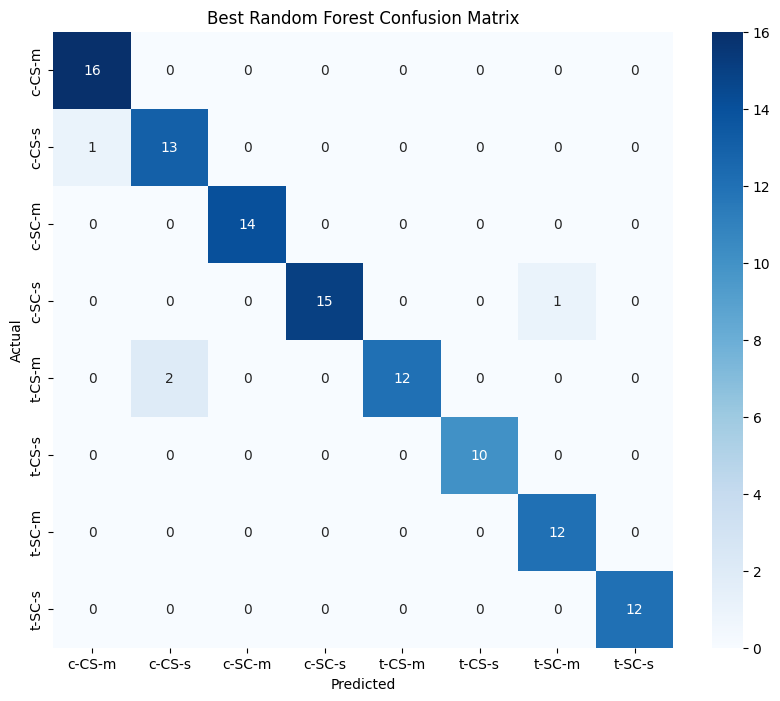


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       0.94      1.00      0.97        16
      c-CS-s       0.87      0.93      0.90        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      0.94      0.97        16
      t-CS-m       1.00      0.86      0.92        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       0.92      1.00      0.96        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           0.96       108
   macro avg       0.97      0.97      0.96       108
weighted avg       0.97      0.96      0.96       108



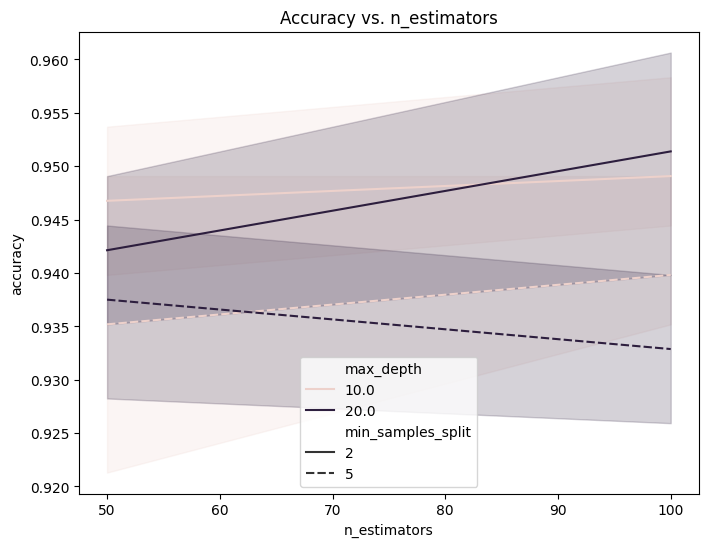

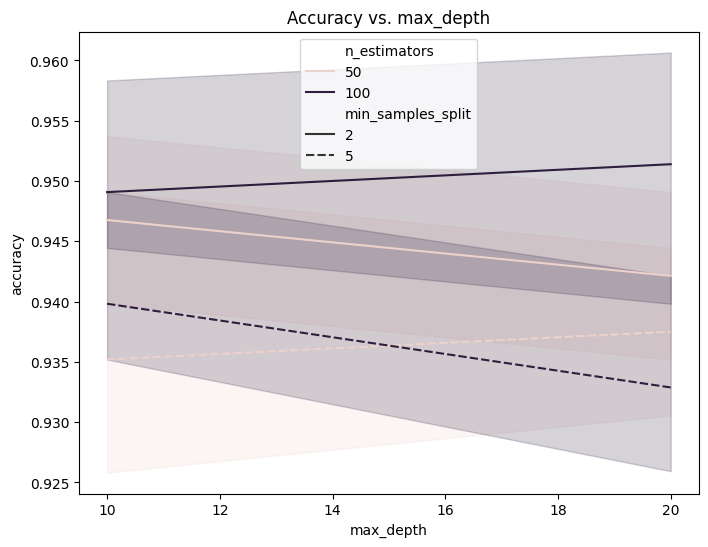

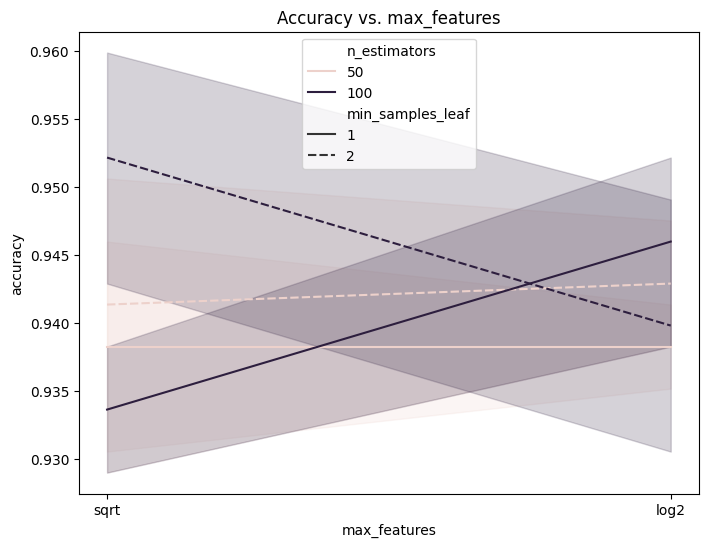


=== Experiments: Scaling=True, Imputation=median, Fraction=0.5, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D


Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.44s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.32s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.83s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.33s, Prediction Time: 0.00s

Testing: n_estimators=50, max_depth=None, min_sample

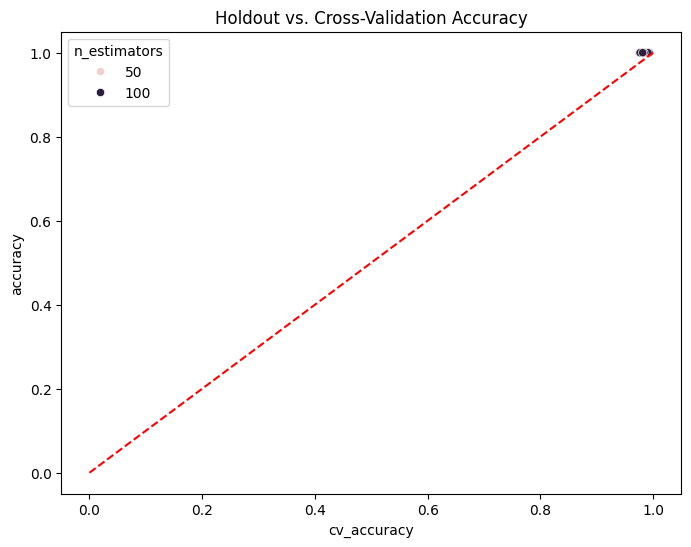


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.0
100    0.0
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.0
20.0    0.0
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.0
5    0.0
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.0
sqrt    0.0
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.0
2    0.0
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


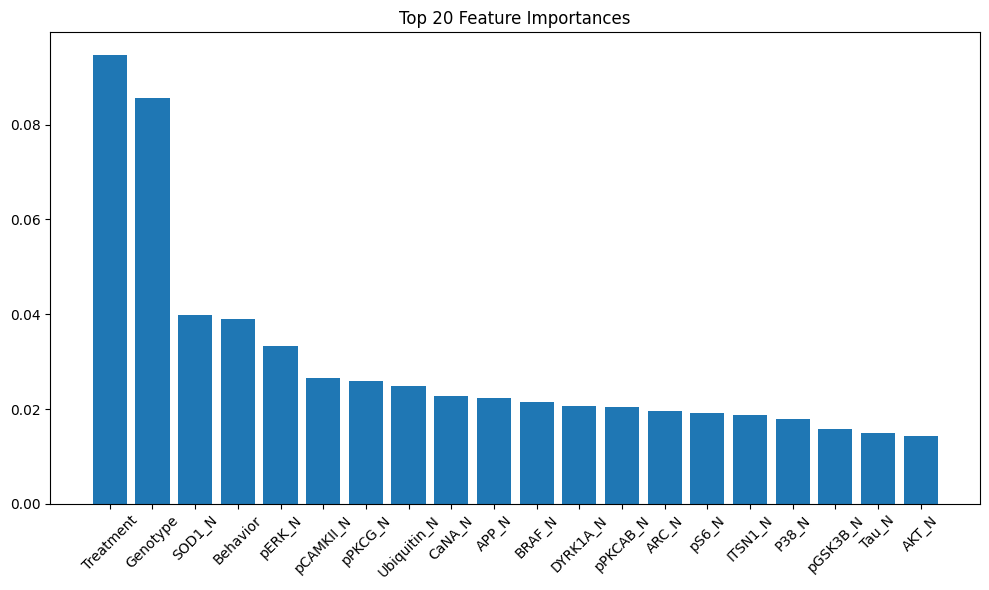

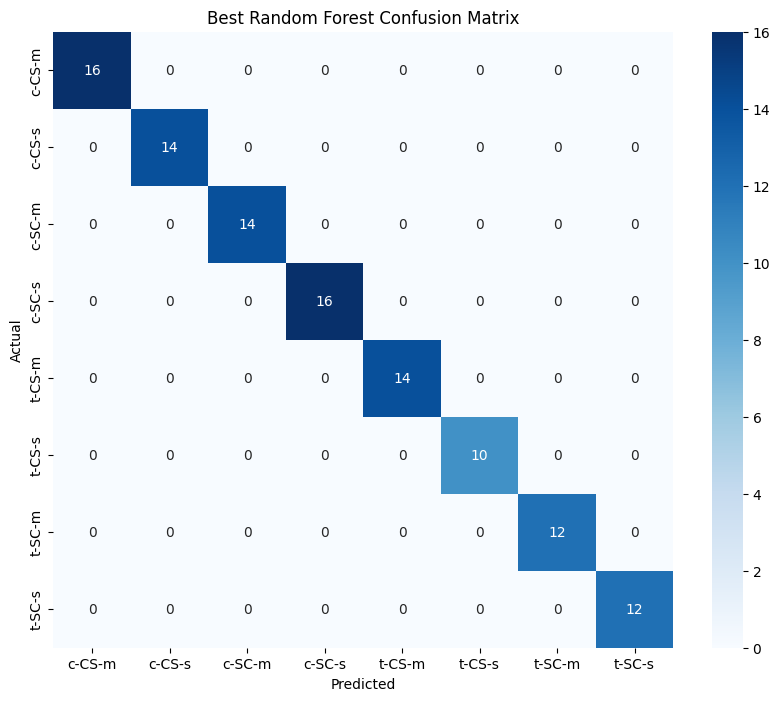


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        16
      c-CS-s       1.00      1.00      1.00        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      1.00      1.00        16
      t-CS-m       1.00      1.00      1.00        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       1.00      1.00      1.00        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



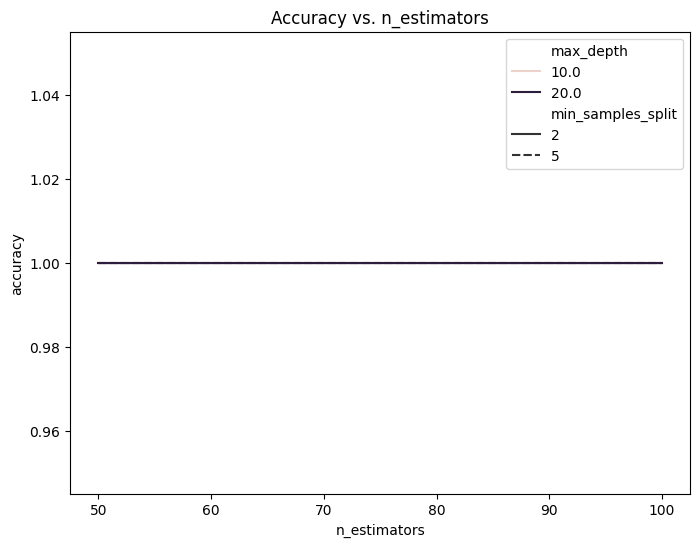

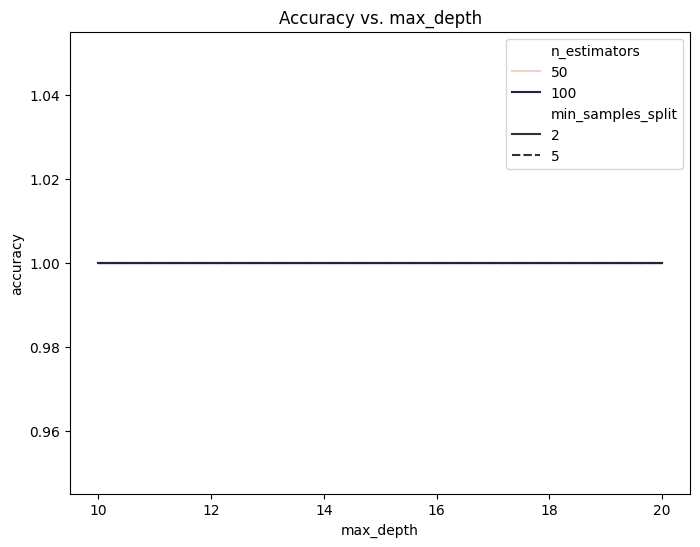

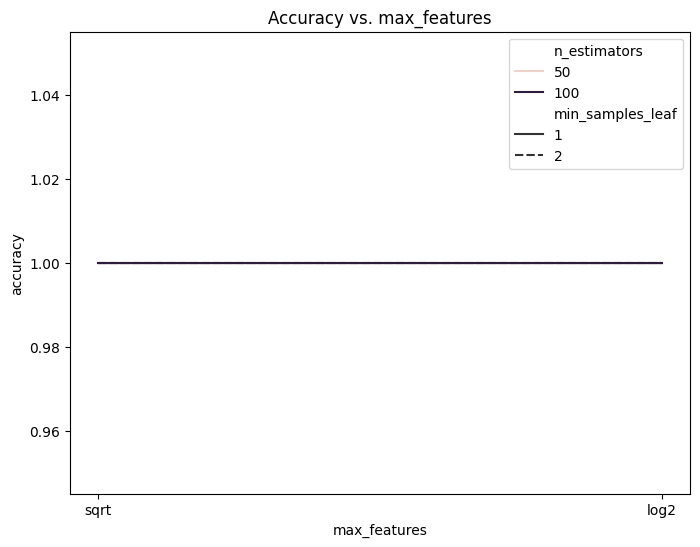


=== Experiments: Scaling=True, Imputation=median, Fraction=1.0, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.41s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.41s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.56s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_sp

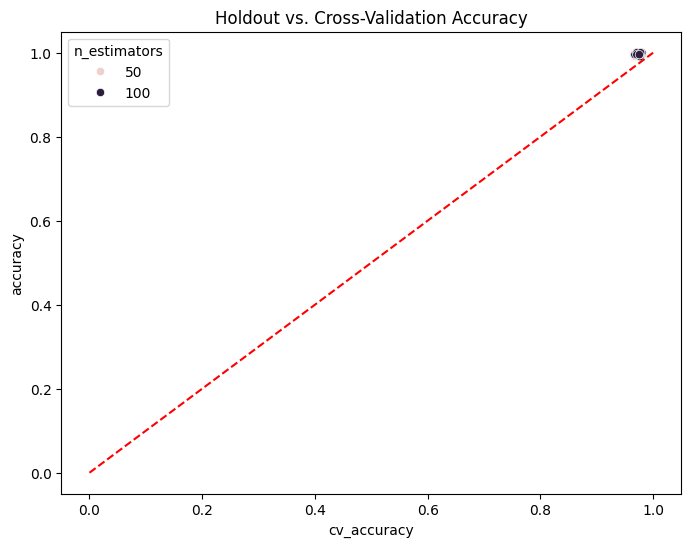


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.003196
100    0.002702
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.003472
20.0    0.003033
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.003338
5    0.002949
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.003525
sqrt    0.002546
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.003046
2    0.003250
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    5
Name: count, dtype: int64
max_depth: max_depth
10.0    3
Name: count, dtype: int64
min_samples_split: min_samples_split
5    5
Name: count, dtype: int64
max_features: max_features
log2    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
2    5
Name: count, dtype: int64


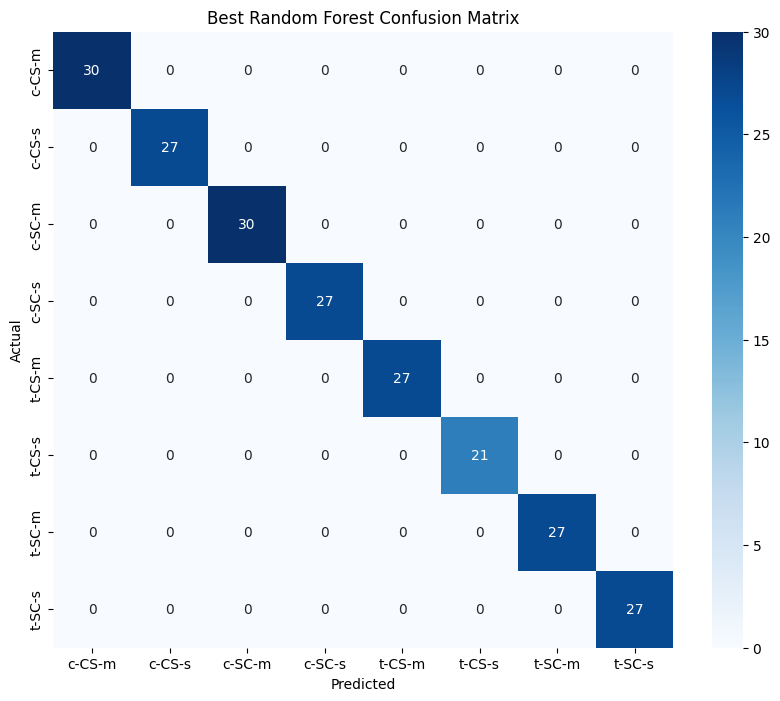


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



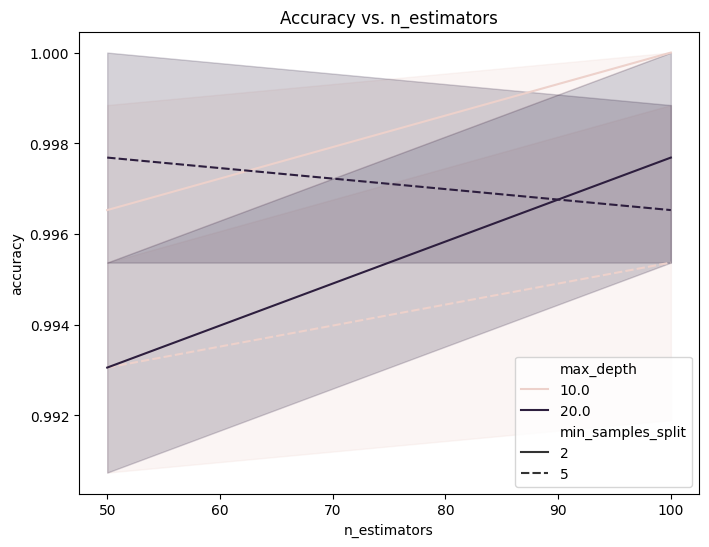

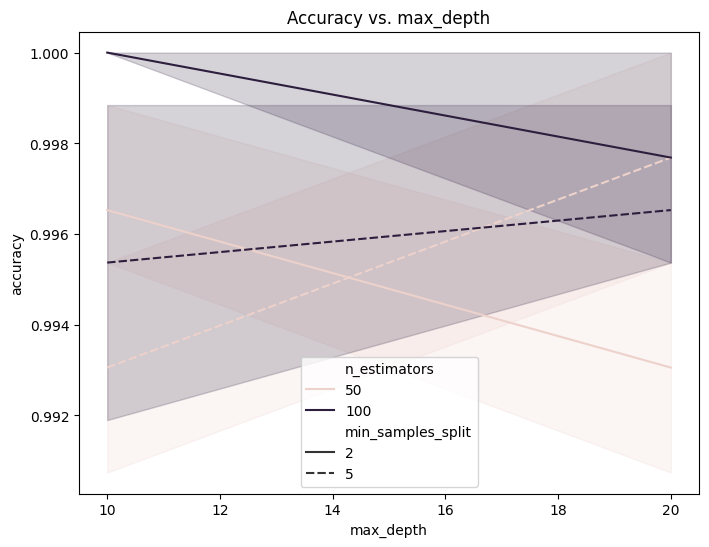


=== Experiments: Scaling=True, Imputation=median, Fraction=1.0, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.44s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.39s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.55s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.53s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.64s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None,

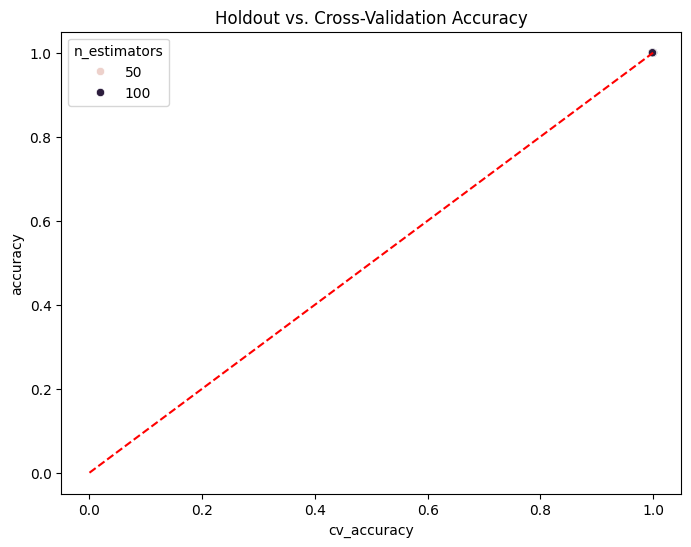


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.0
100    0.0
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.0
20.0    0.0
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.0
5    0.0
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.0
sqrt    0.0
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.0
2    0.0
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


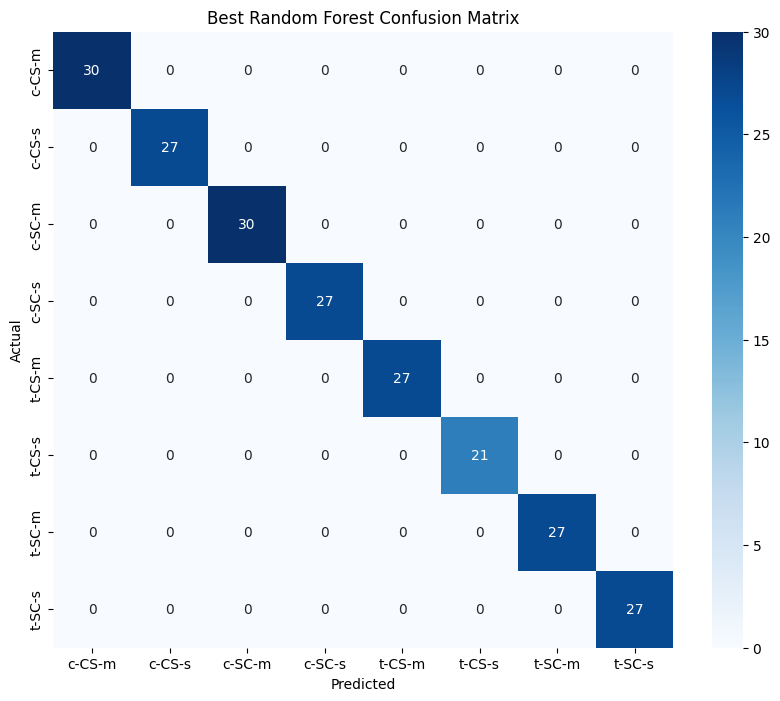


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



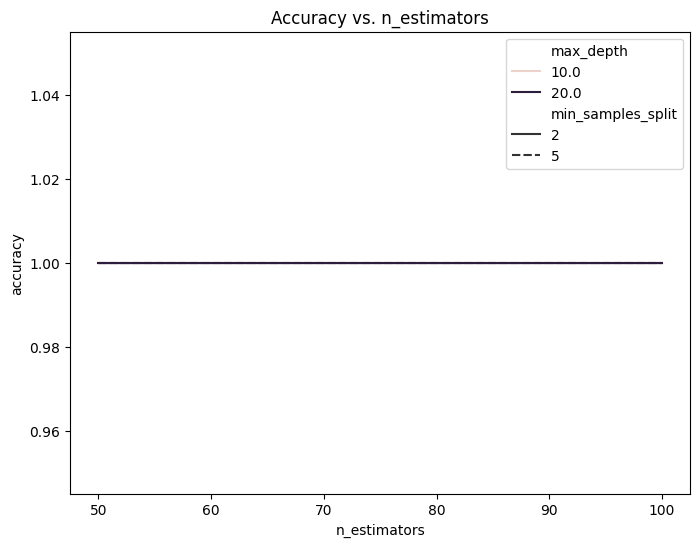

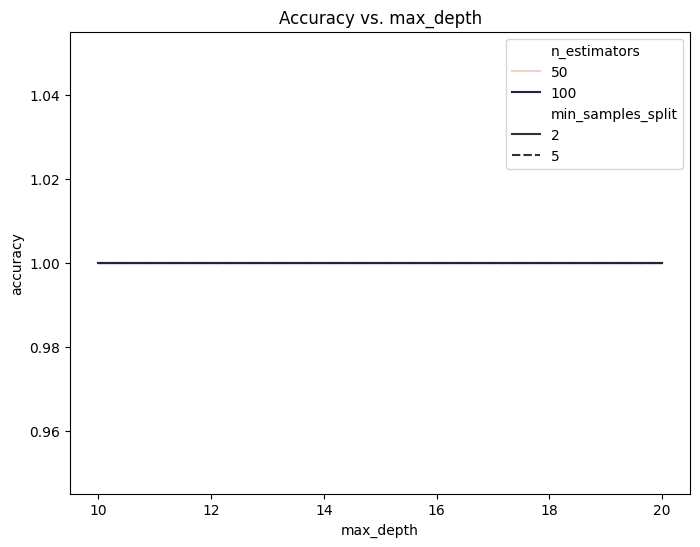

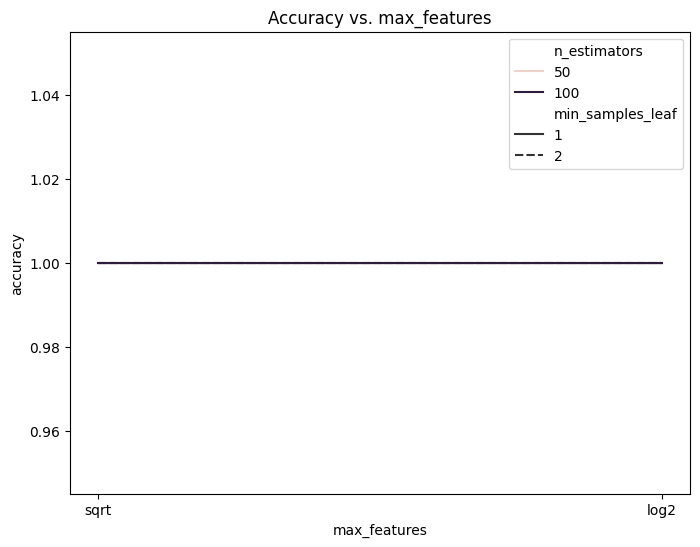


=== Experiments: Scaling=False, Imputation=mean, Fraction=0.5, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.92, F1-Score: 0.92, ROC-AUC: 1.00, CV Accuracy: 0.92
Training Time: 0.47s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.95, F1-Score: 0.95, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.43s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.94, F1-Score: 0.94, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.24s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_spli

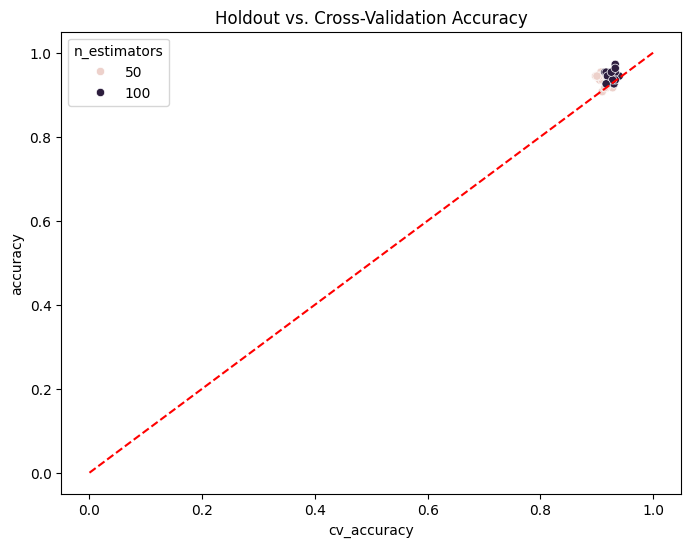


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.014955
100    0.012782
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.011651
20.0    0.015677
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.014783
5    0.013782
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.015120
sqrt    0.014426
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.015798
2    0.013370
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    7
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
5    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


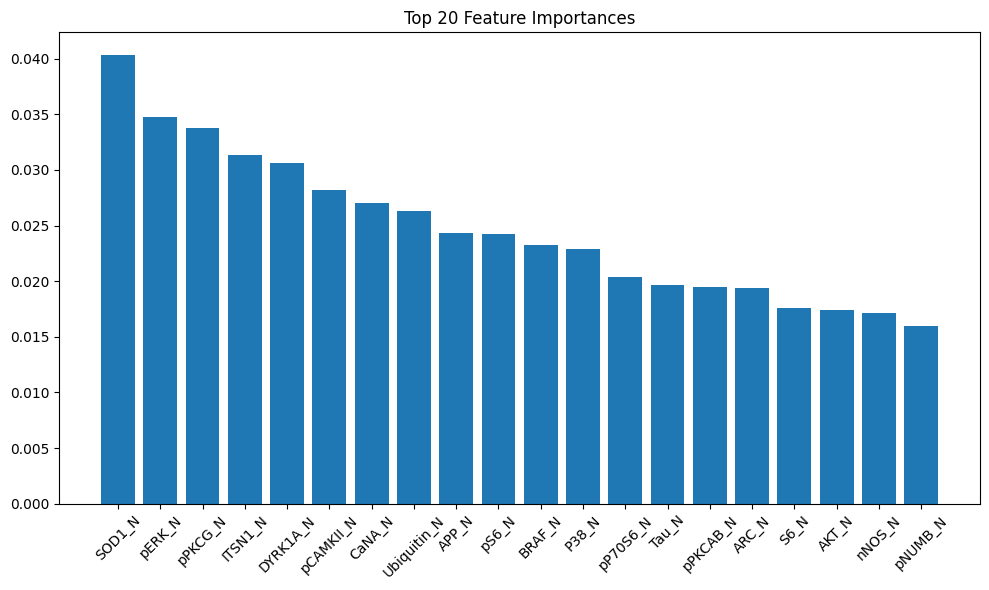

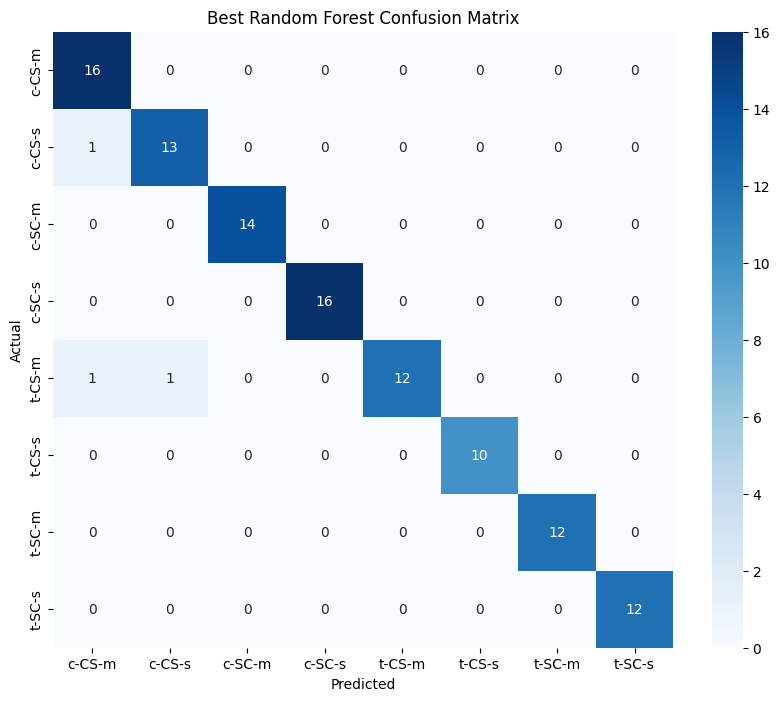


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       0.89      1.00      0.94        16
      c-CS-s       0.93      0.93      0.93        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      1.00      1.00        16
      t-CS-m       1.00      0.86      0.92        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       1.00      1.00      1.00        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           0.97       108
   macro avg       0.98      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108



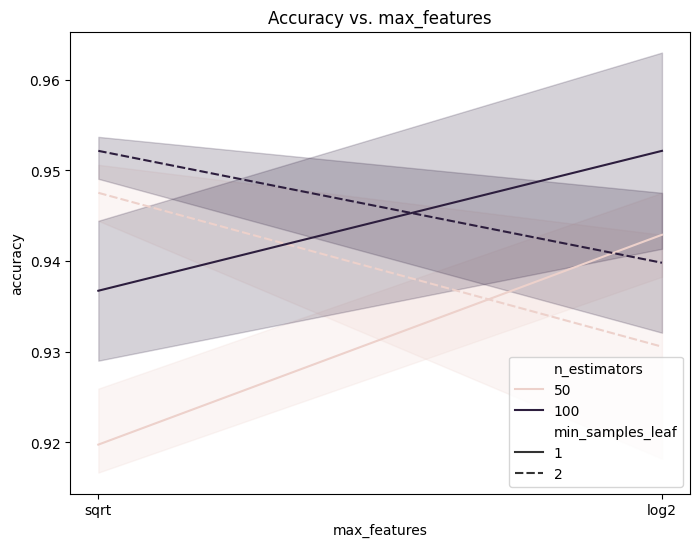


=== Experiments: Scaling=False, Imputation=mean, Fraction=0.5, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.46s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.42s, Prediction Time: 0.03s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.66s, Prediction Time: 0.03s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.31s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.48s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None,

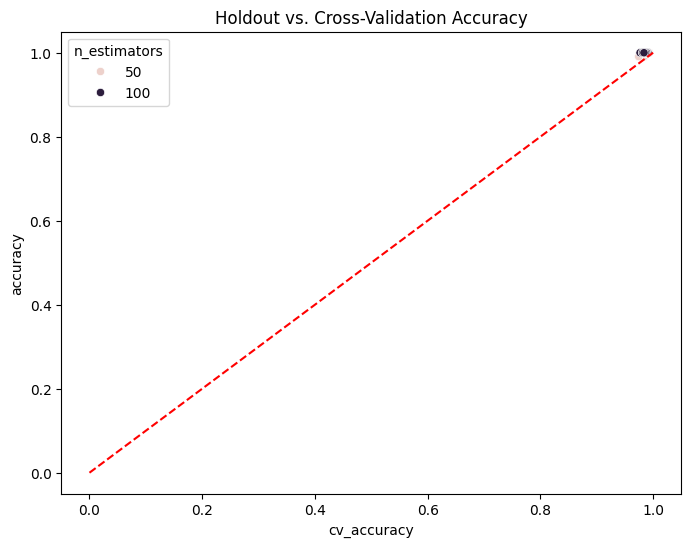


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.003841
100    0.000000
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.002315
20.0    0.003163
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.003841
5    0.000000
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.003841
sqrt    0.000000
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.002614
2    0.003128
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    5
Name: count, dtype: int64
max_features: max_features
sqrt    7
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    6
Name: count, dtype: int64


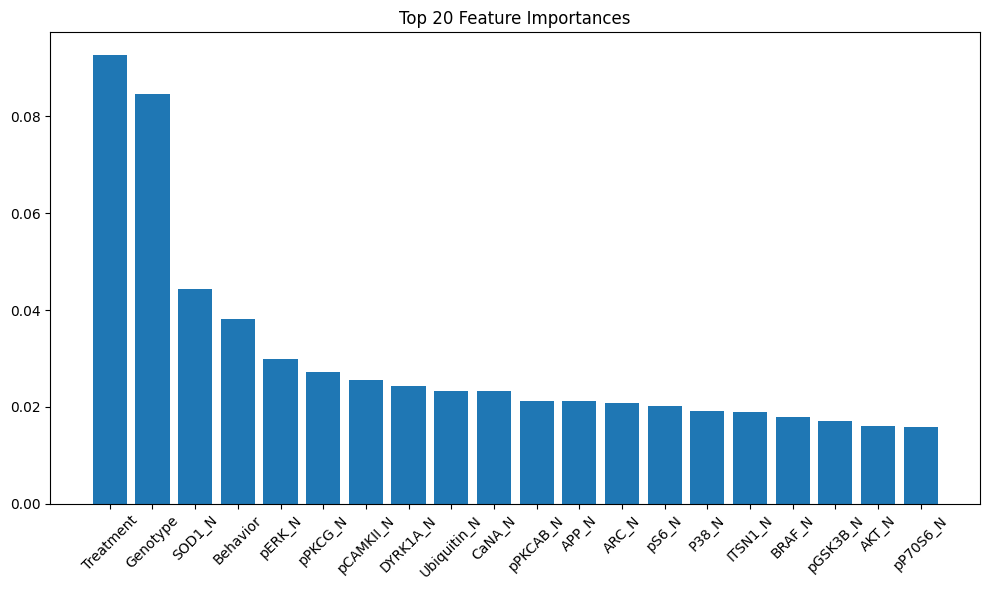

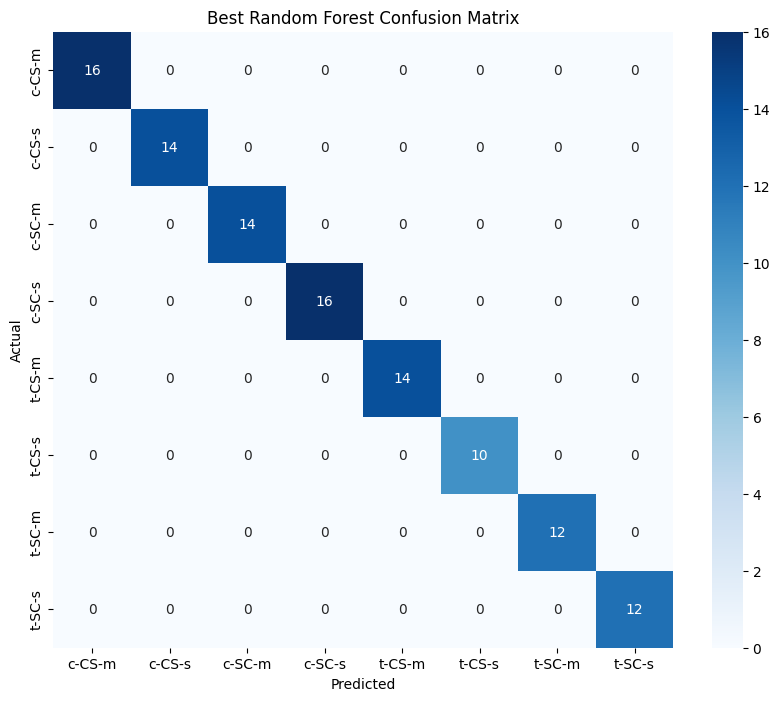


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        16
      c-CS-s       1.00      1.00      1.00        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      1.00      1.00        16
      t-CS-m       1.00      1.00      1.00        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       1.00      1.00      1.00        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



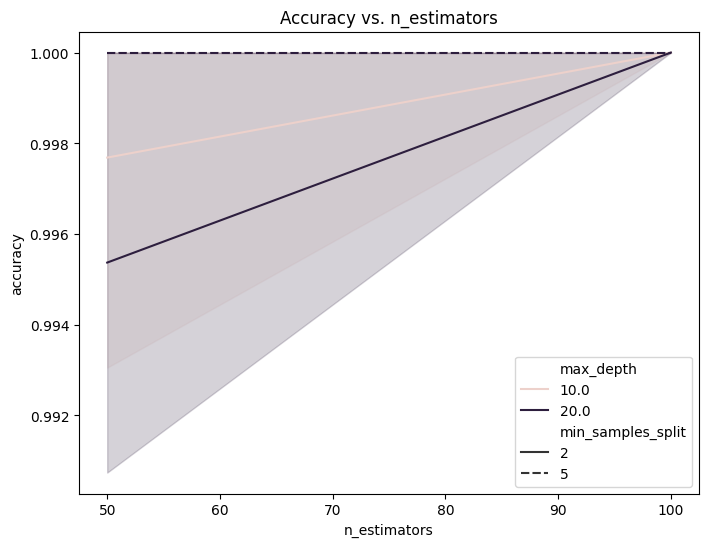

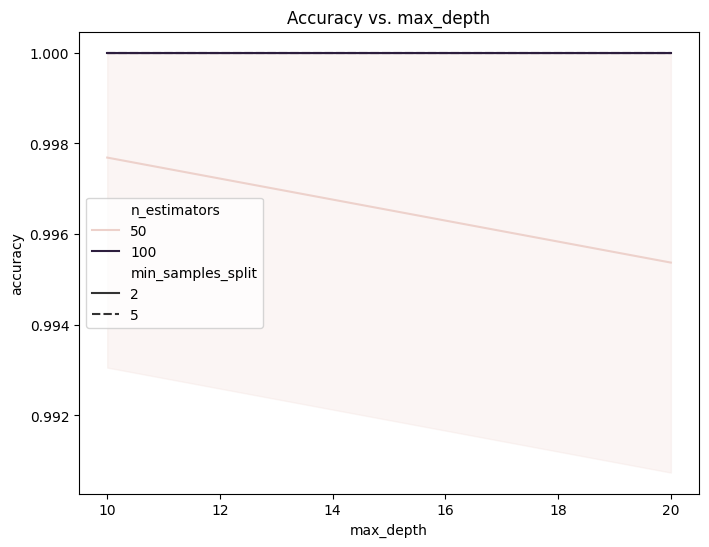

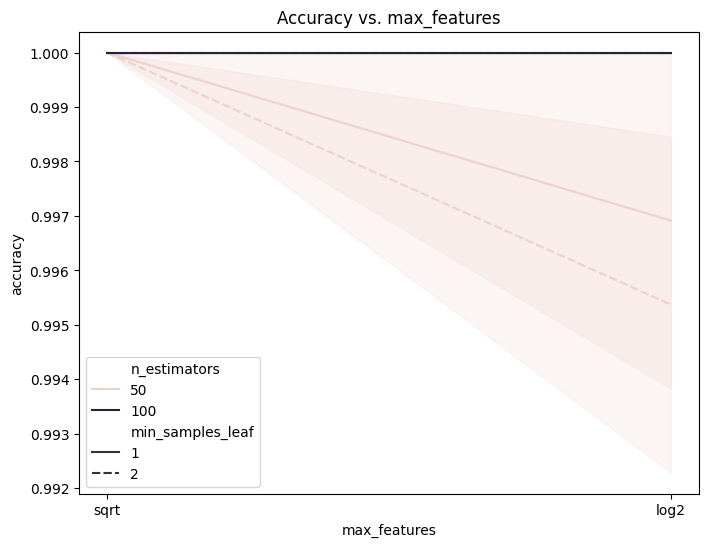


=== Experiments: Scaling=False, Imputation=mean, Fraction=1.0, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.45s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.96
Training Time: 0.42s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.55s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_spl

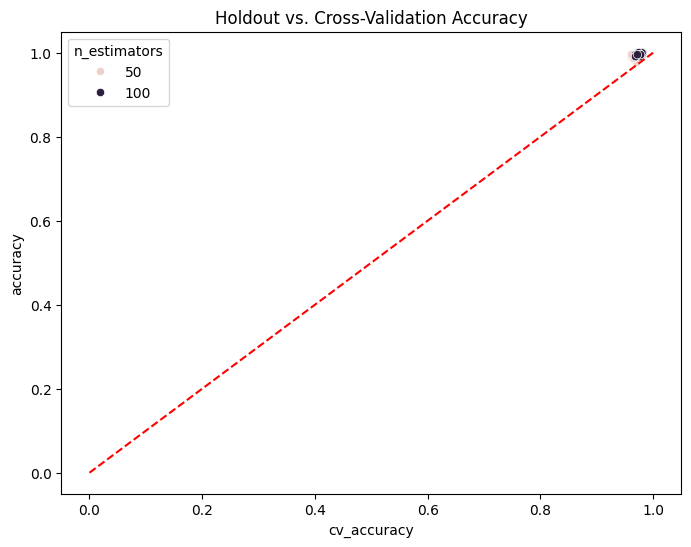


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.006355
100    0.003590
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.007147
20.0    0.004098
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.004981
5    0.005254
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.002365
sqrt    0.005670
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.003734
2    0.005789
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    7
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    8
Name: count, dtype: int64
max_features: max_features
log2    8
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    8
Name: count, dtype: int64


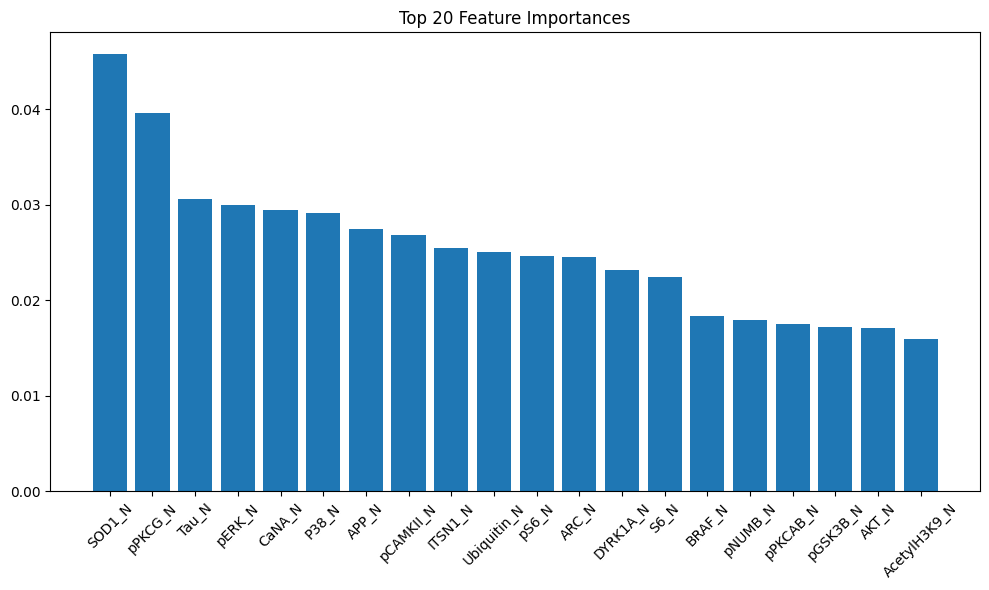

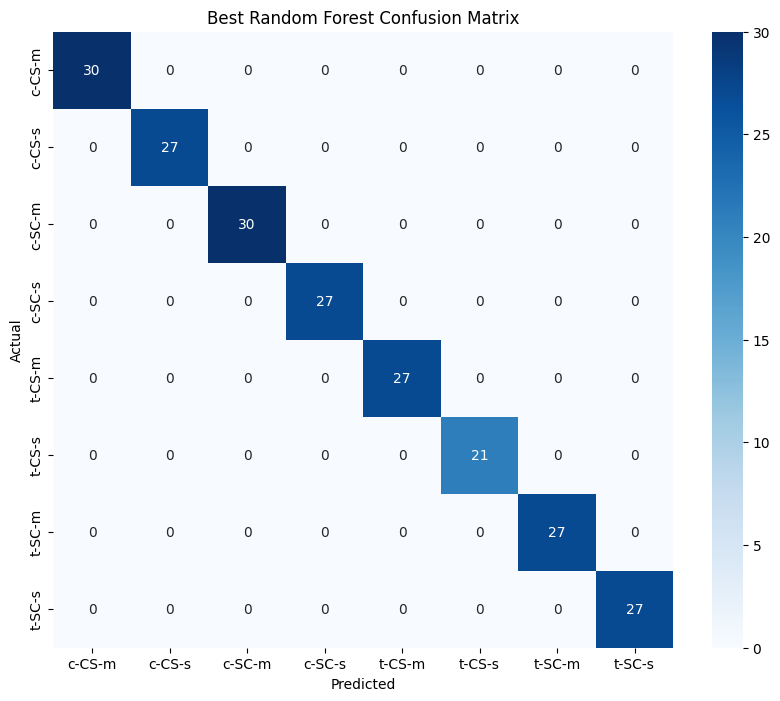


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



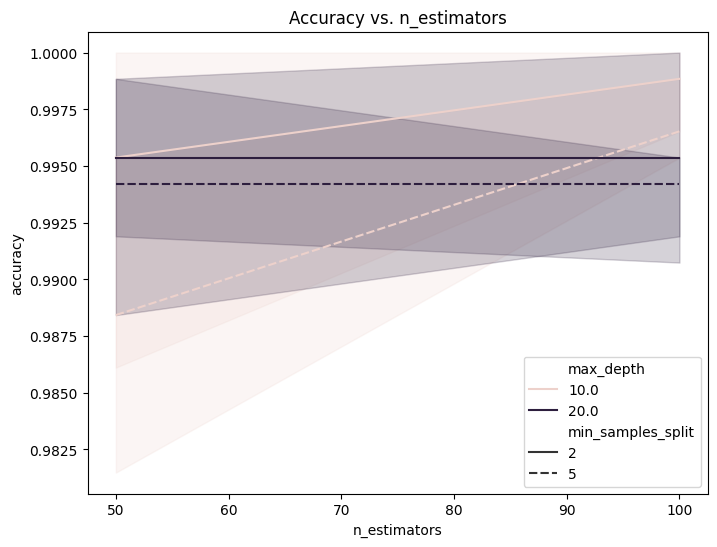

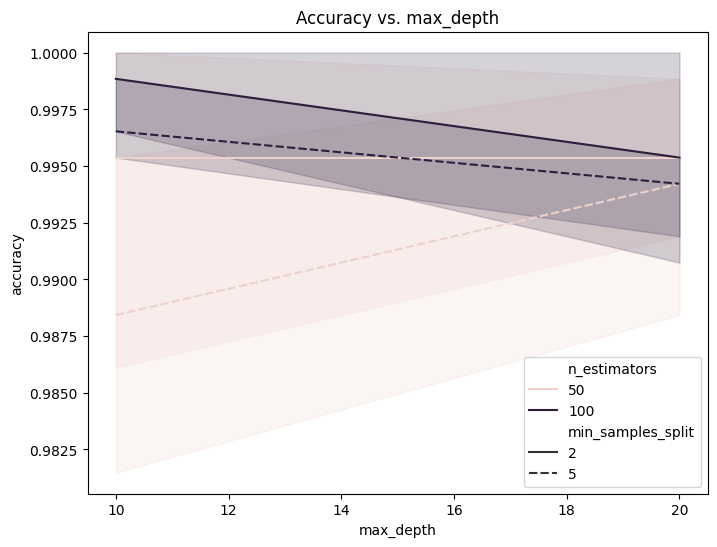

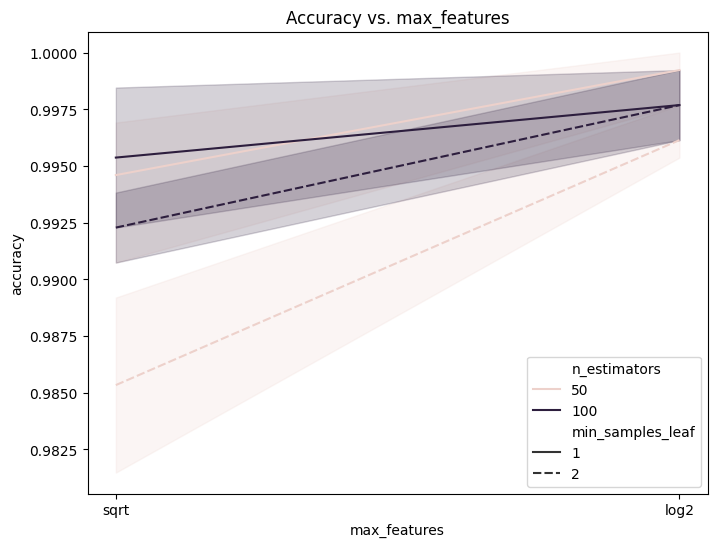


=== Experiments: Scaling=False, Imputation=mean, Fraction=1.0, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.38s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.69s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.34s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.64s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.55s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None,

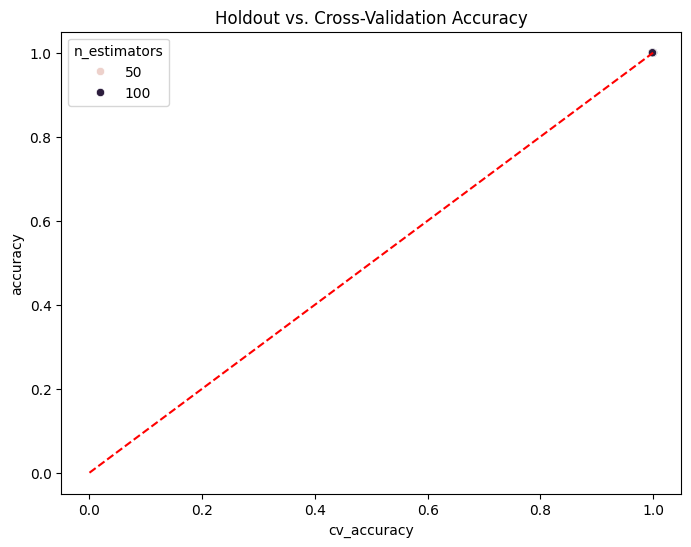


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.0
100    0.0
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.0
20.0    0.0
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.0
5    0.0
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.0
sqrt    0.0
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.0
2    0.0
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


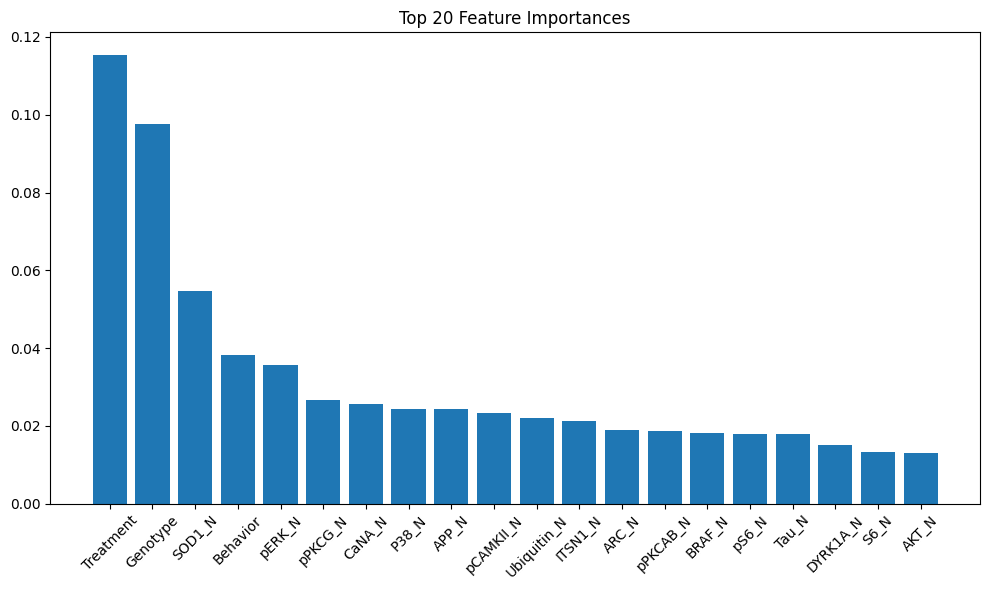

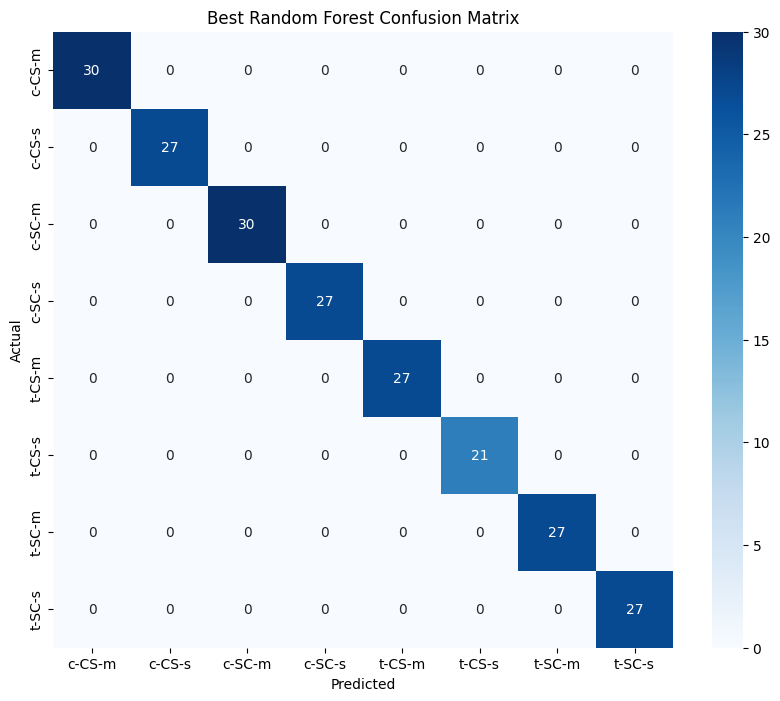


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



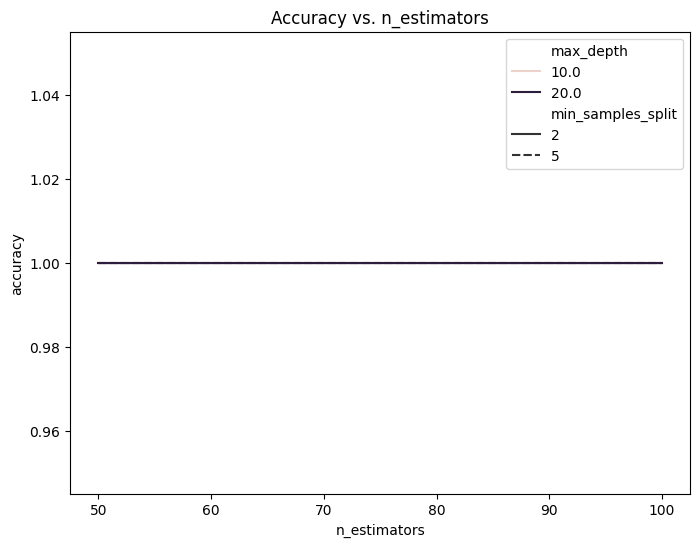

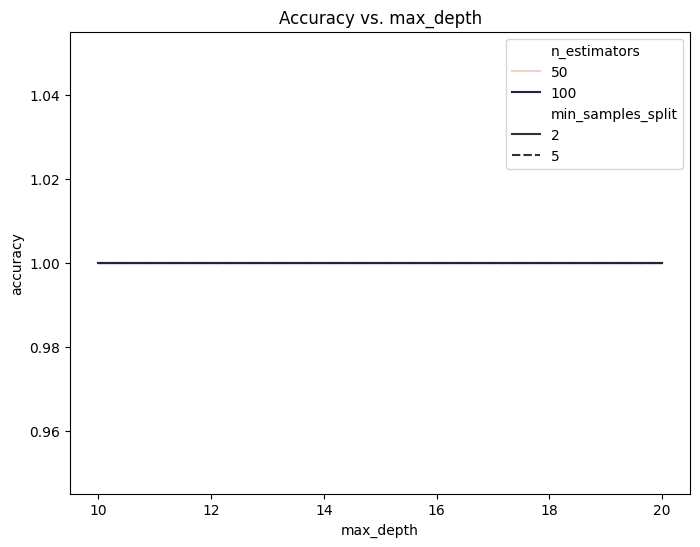

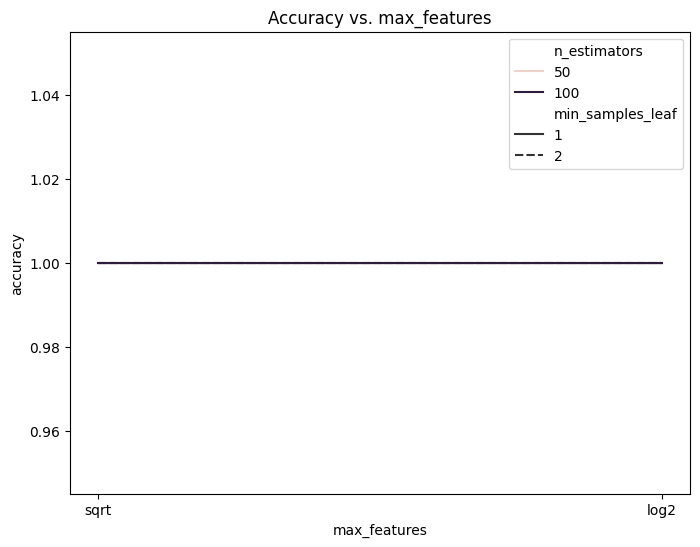


=== Experiments: Scaling=False, Imputation=median, Fraction=0.5, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.94, F1-Score: 0.94, ROC-AUC: 1.00, CV Accuracy: 0.92
Training Time: 0.48s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.95, F1-Score: 0.95, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.23s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.94, F1-Score: 0.94, ROC-AUC: 1.00, CV Accuracy: 0.91
Training Time: 0.19s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_sp

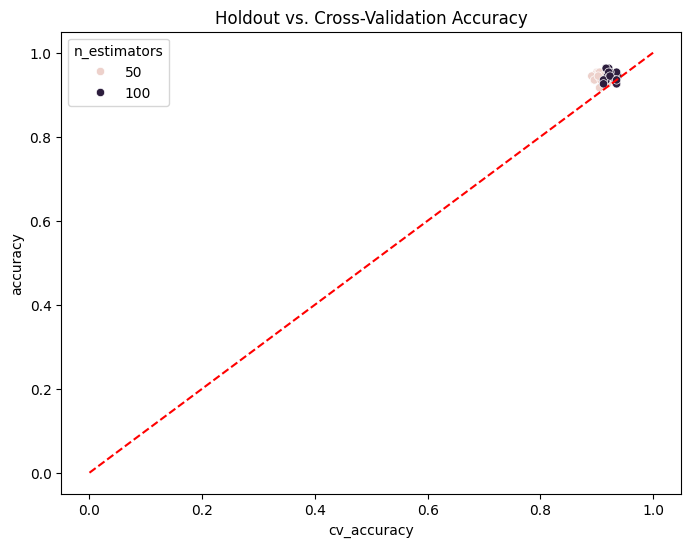


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.009837
100    0.012109
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.011324
20.0    0.011150
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.009645
5    0.009426
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.008839
sqrt    0.012999
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.009021
2    0.012356
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    5
Name: count, dtype: int64
max_depth: max_depth
10.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    9
Name: count, dtype: int64
max_features: max_features
sqrt    7
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
2    8
Name: count, dtype: int64


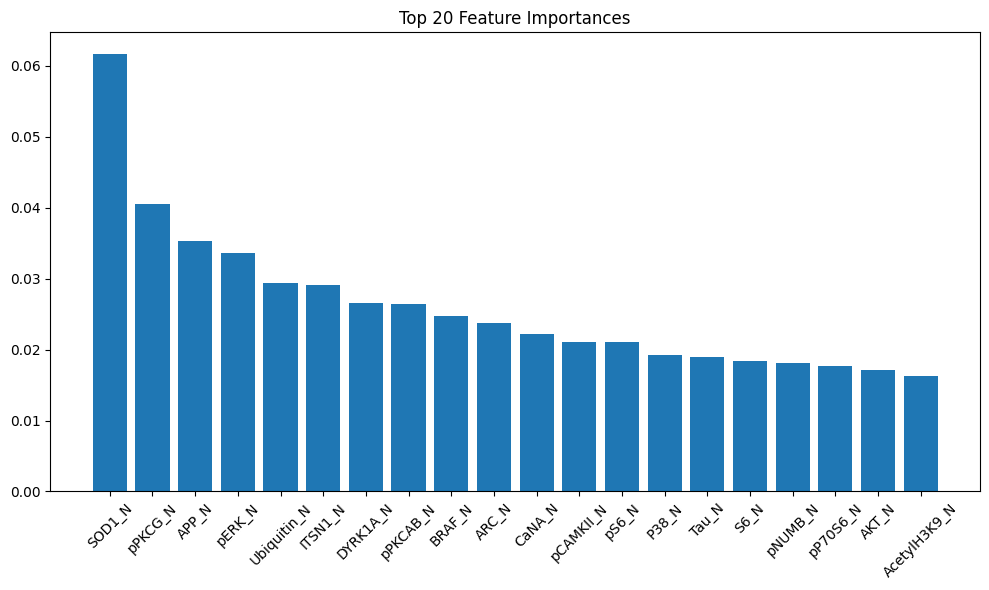

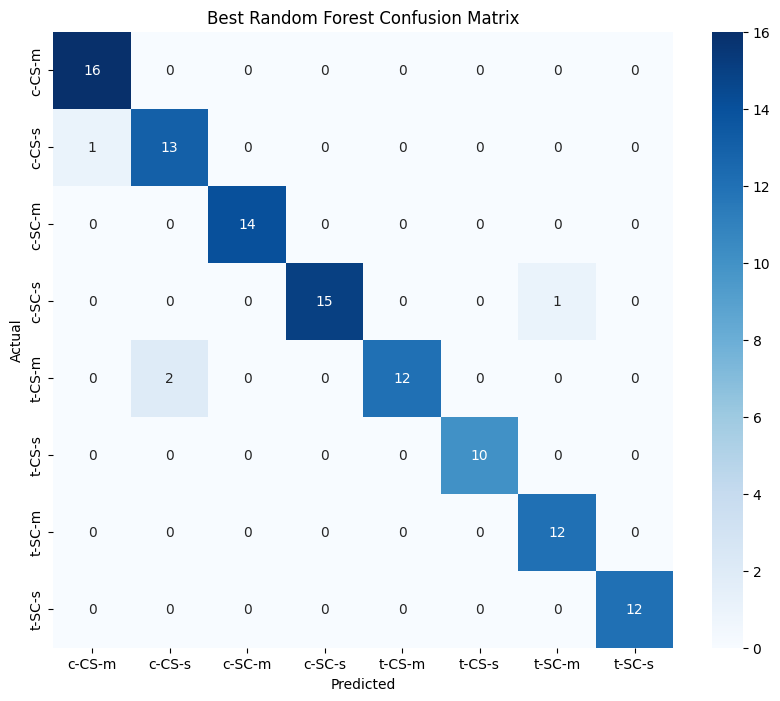


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       0.94      1.00      0.97        16
      c-CS-s       0.87      0.93      0.90        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      0.94      0.97        16
      t-CS-m       1.00      0.86      0.92        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       0.92      1.00      0.96        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           0.96       108
   macro avg       0.97      0.97      0.96       108
weighted avg       0.97      0.96      0.96       108



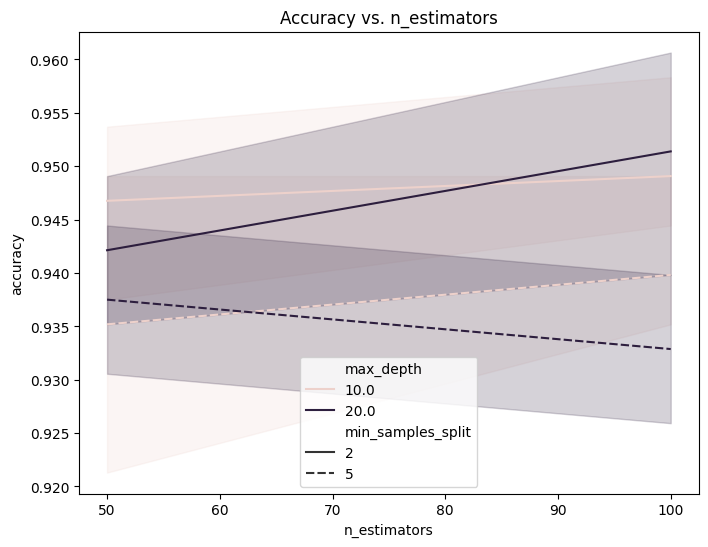

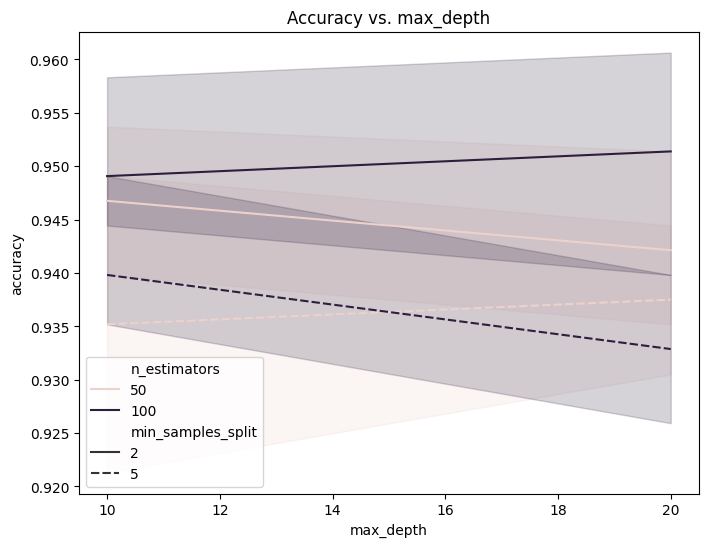

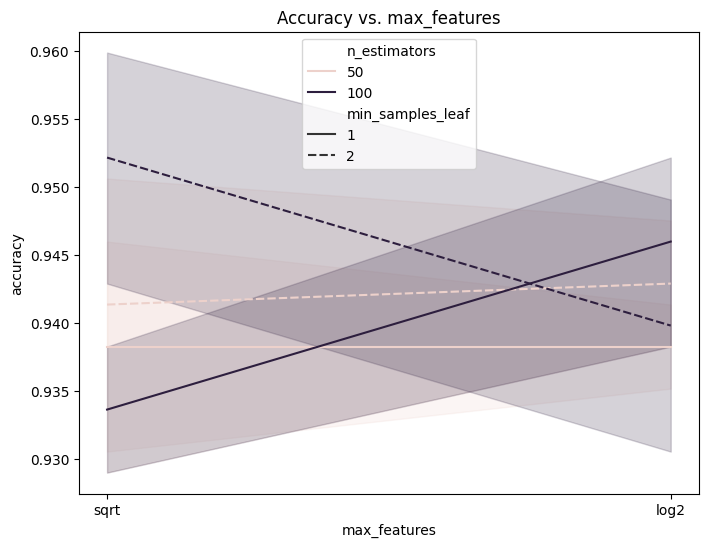


=== Experiments: Scaling=False, Imputation=median, Fraction=0.5, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 540, Training samples: 432, Testing samples: 108

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.35s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.20s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.18s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.18s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.99
Training Time: 0.20s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None,

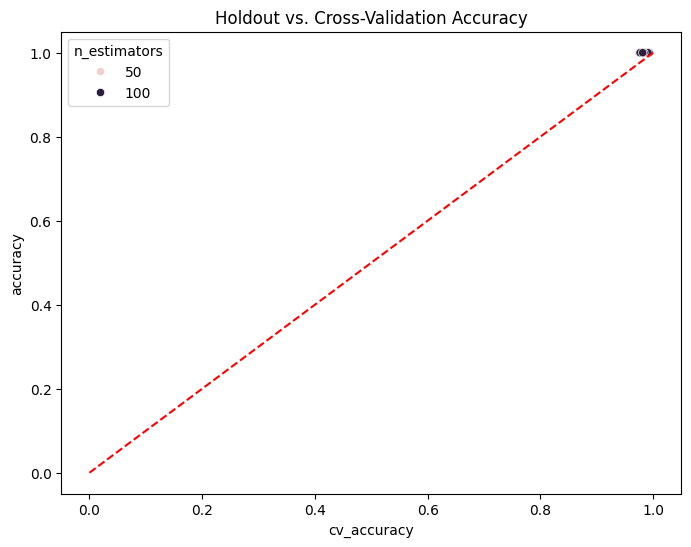


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.0
100    0.0
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.0
20.0    0.0
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.0
5    0.0
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.0
sqrt    0.0
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.0
2    0.0
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


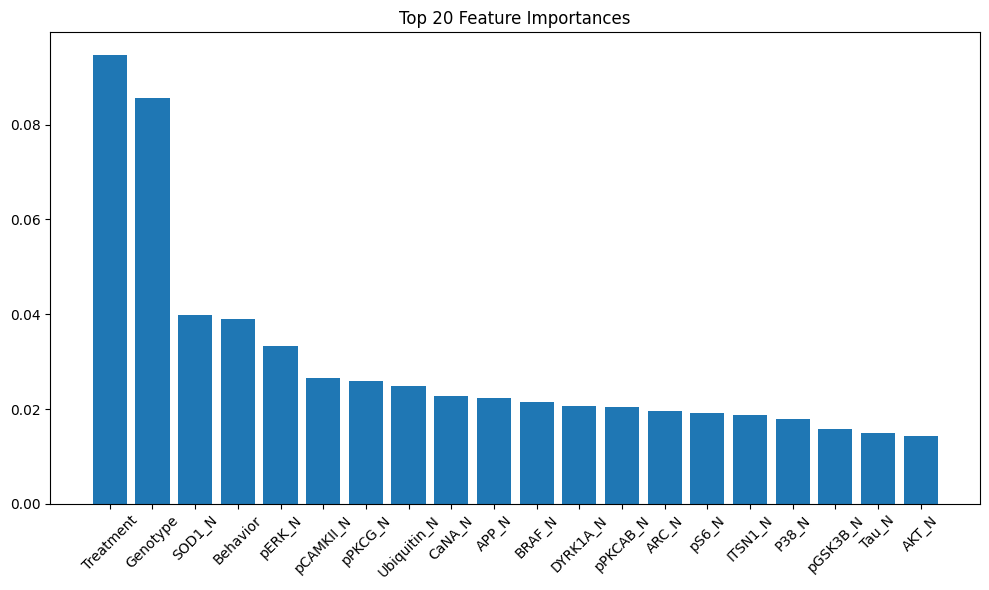

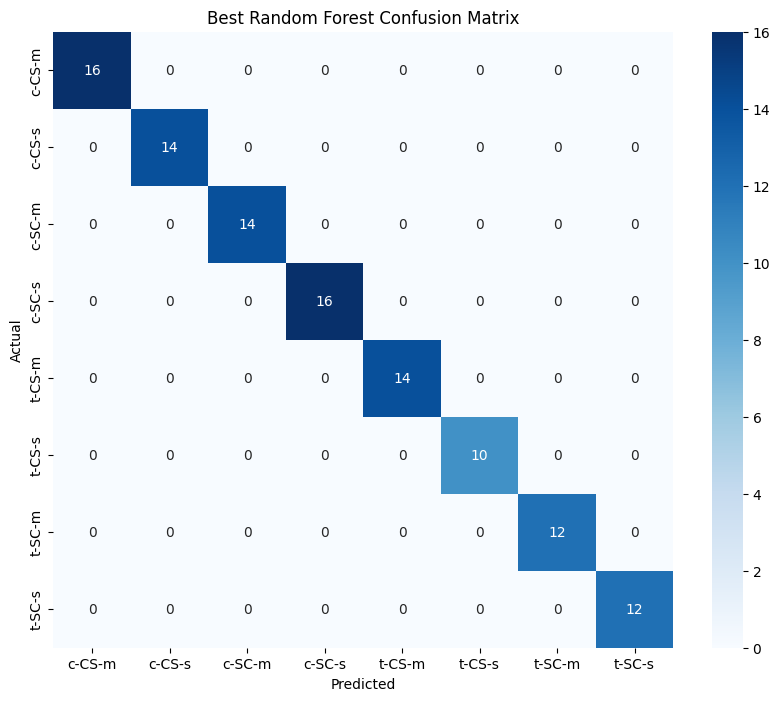


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        16
      c-CS-s       1.00      1.00      1.00        14
      c-SC-m       1.00      1.00      1.00        14
      c-SC-s       1.00      1.00      1.00        16
      t-CS-m       1.00      1.00      1.00        14
      t-CS-s       1.00      1.00      1.00        10
      t-SC-m       1.00      1.00      1.00        12
      t-SC-s       1.00      1.00      1.00        12

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



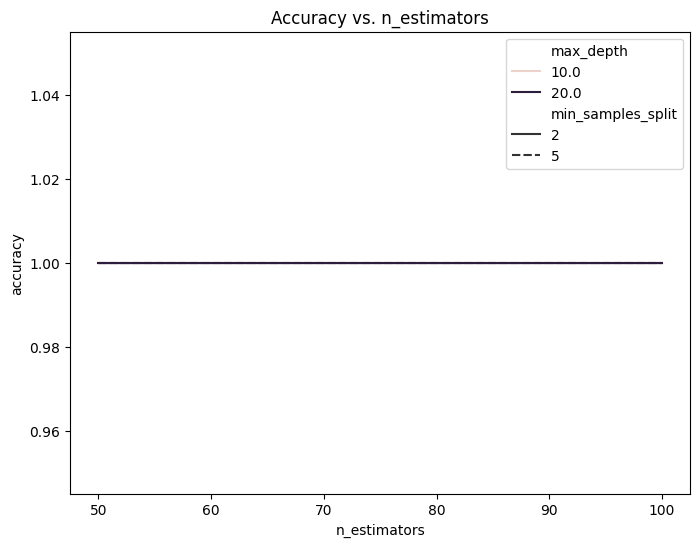

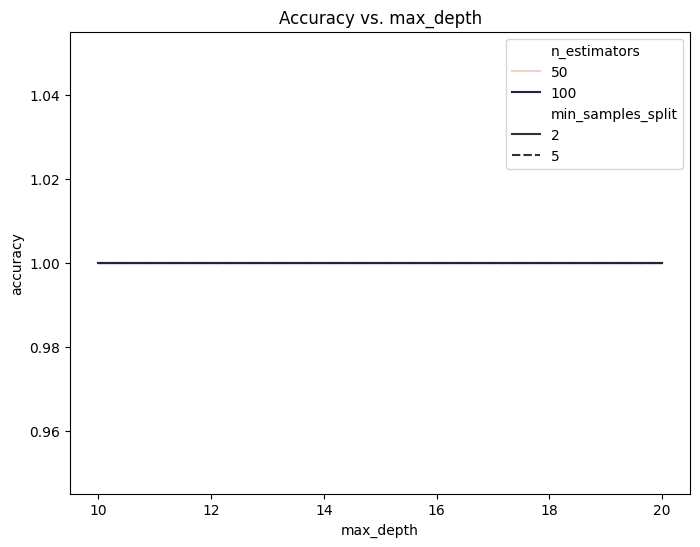

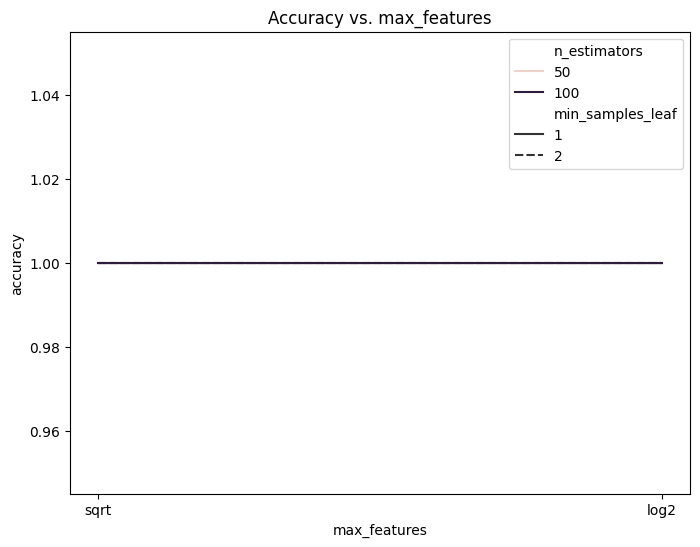


=== Experiments: Scaling=False, Imputation=median, Fraction=1.0, Categorical=False ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.96s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.40s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.58s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_s

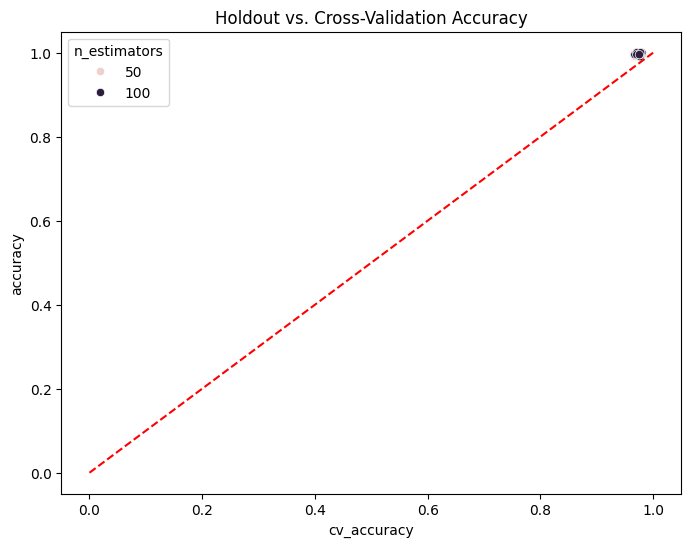


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.003196
100    0.002702
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.003472
20.0    0.003033
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.003338
5    0.002949
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.003525
sqrt    0.002546
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.003046
2    0.003250
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    5
Name: count, dtype: int64
max_depth: max_depth
10.0    3
Name: count, dtype: int64
min_samples_split: min_samples_split
5    5
Name: count, dtype: int64
max_features: max_features
log2    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
2    5
Name: count, dtype: int64


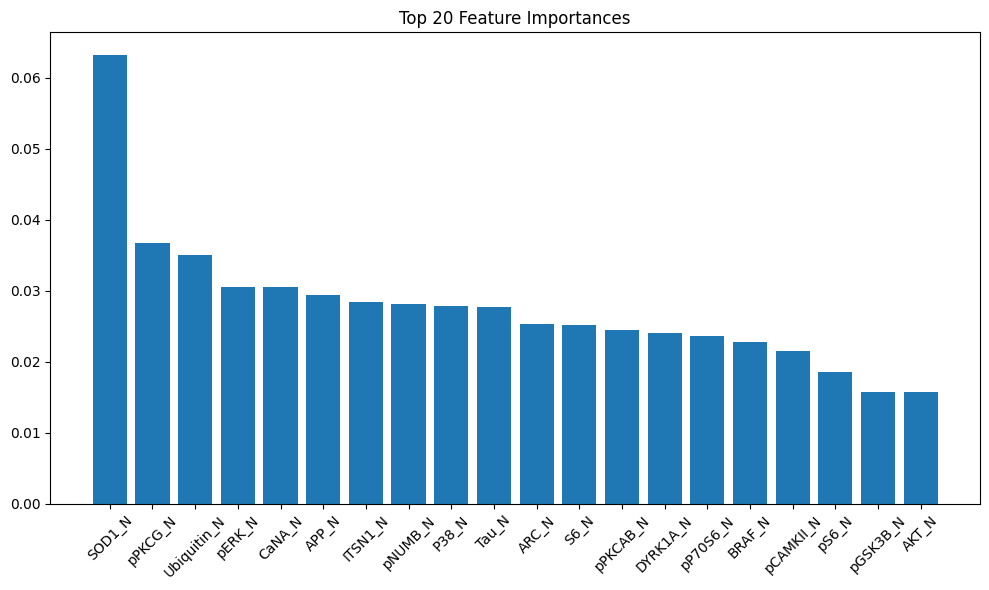

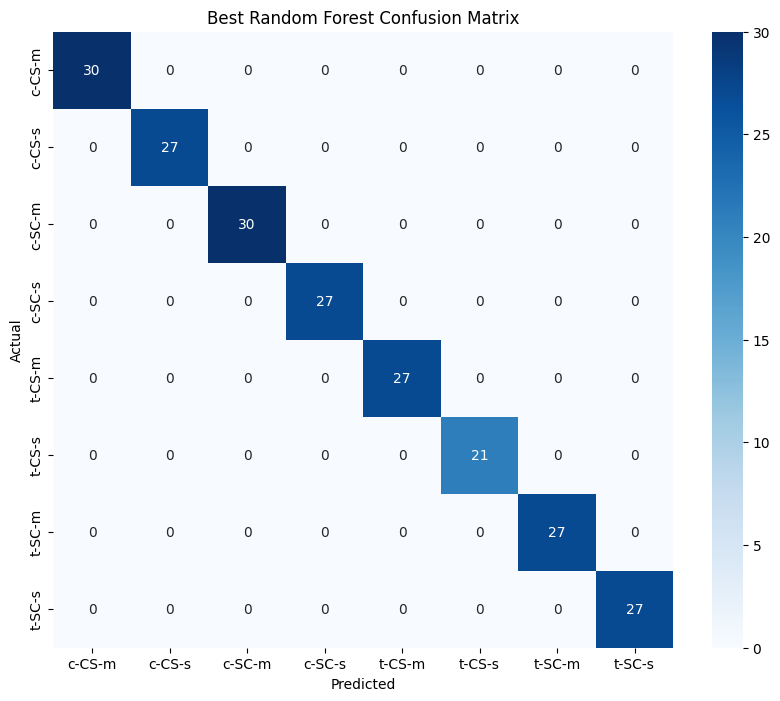


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



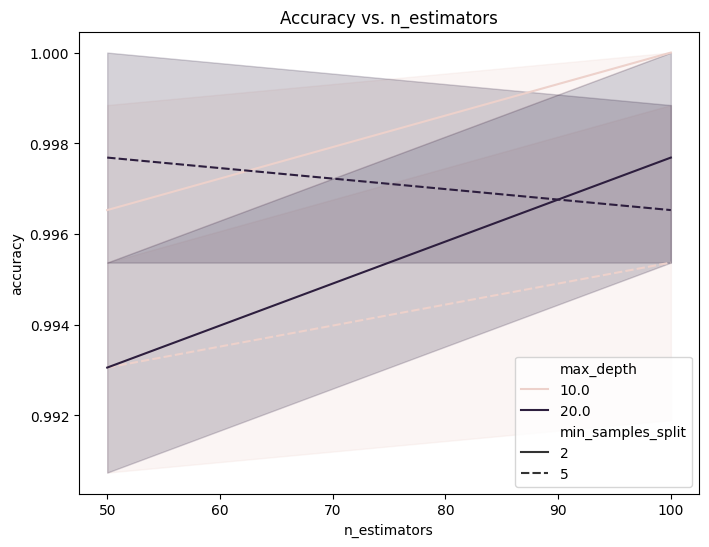

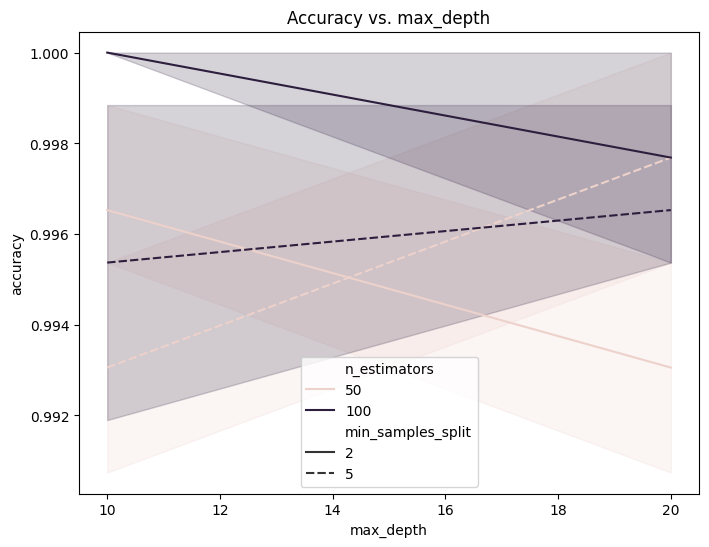

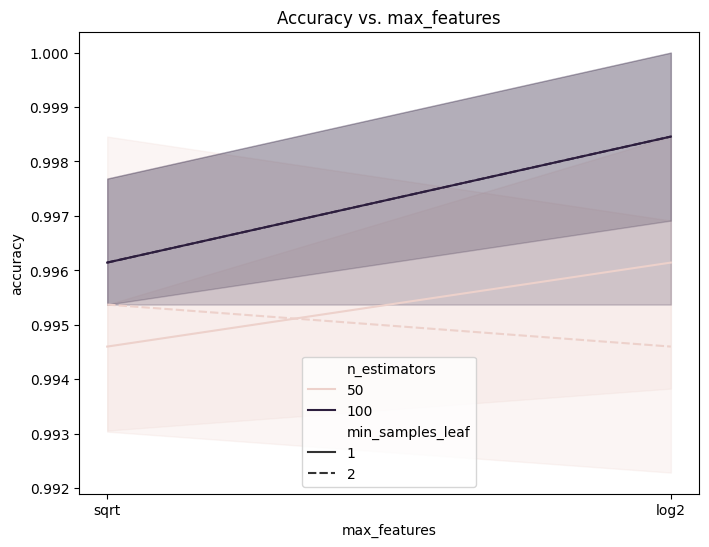


=== Experiments: Scaling=False, Imputation=median, Fraction=1.0, Categorical=True ===

Missing values after imputation: 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Dataset size: 1080, Training samples: 864, Testing samples: 216

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_53004/996482162.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.57s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.41s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.54s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.60s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 1.00, F1-Score: 1.00, ROC-AUC: 1.00, CV Accuracy: 1.00
Training Time: 0.52s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None,

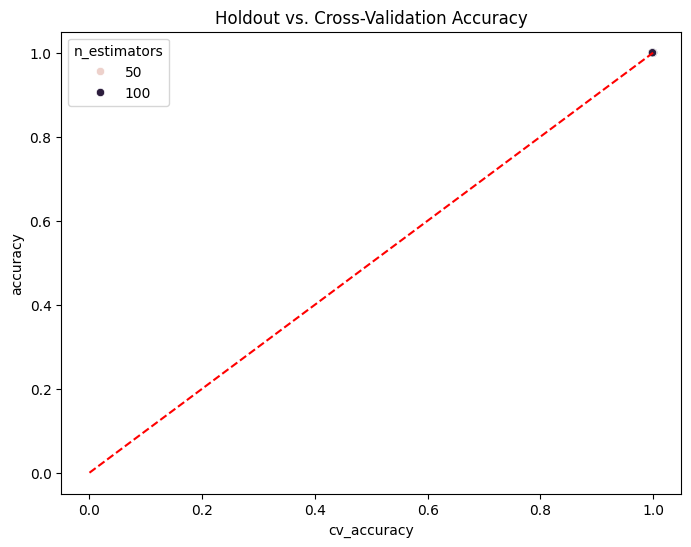


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.0
100    0.0
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.0
20.0    0.0
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.0
5    0.0
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.0
sqrt    0.0
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.0
2    0.0
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
50    10
Name: count, dtype: int64
max_depth: max_depth
10.0    2
Name: count, dtype: int64
min_samples_split: min_samples_split
2    6
Name: count, dtype: int64
max_features: max_features
sqrt    6
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    5
Name: count, dtype: int64


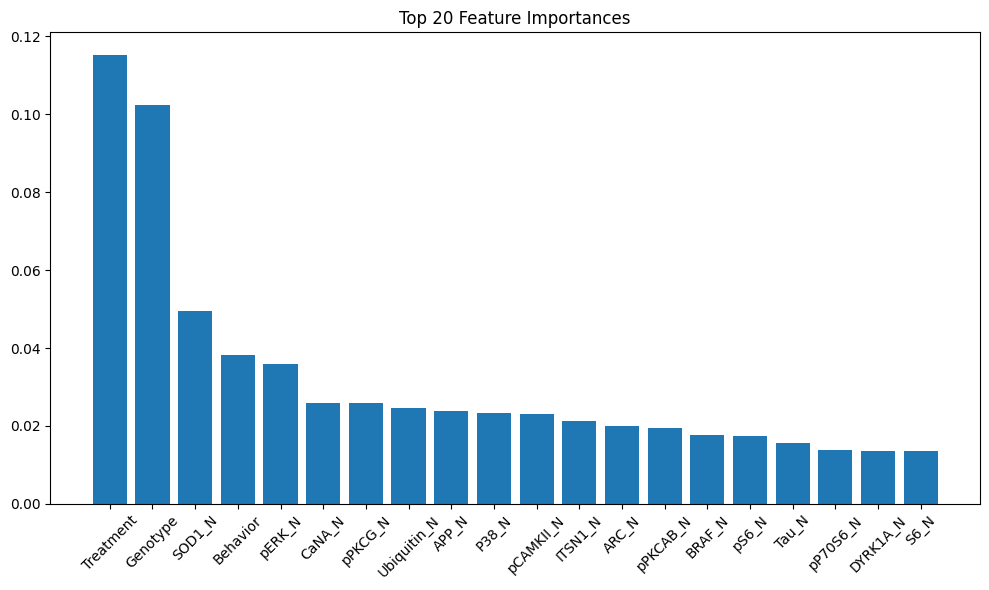

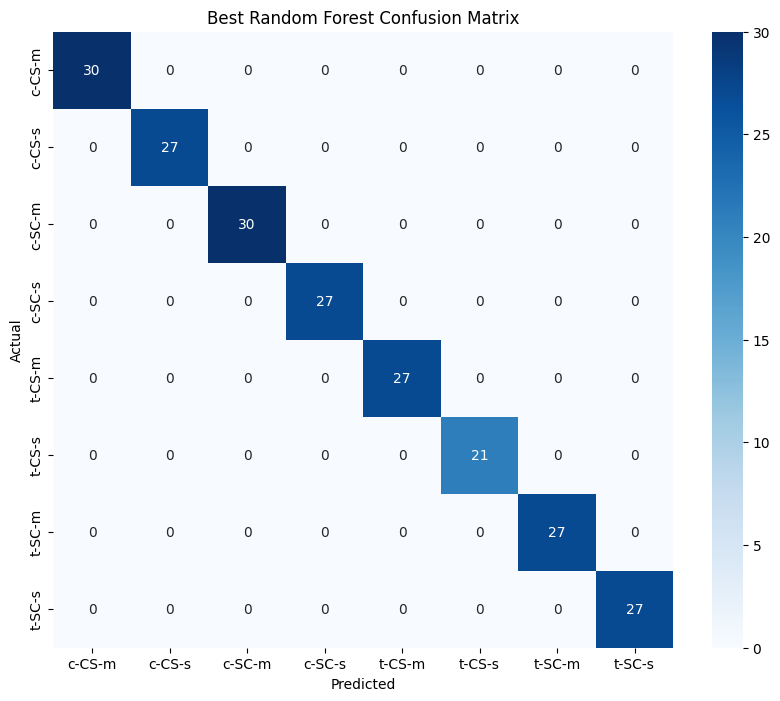


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



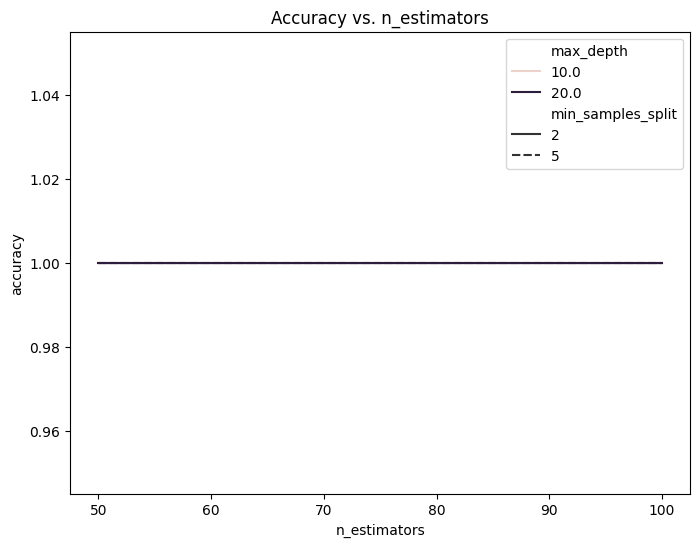

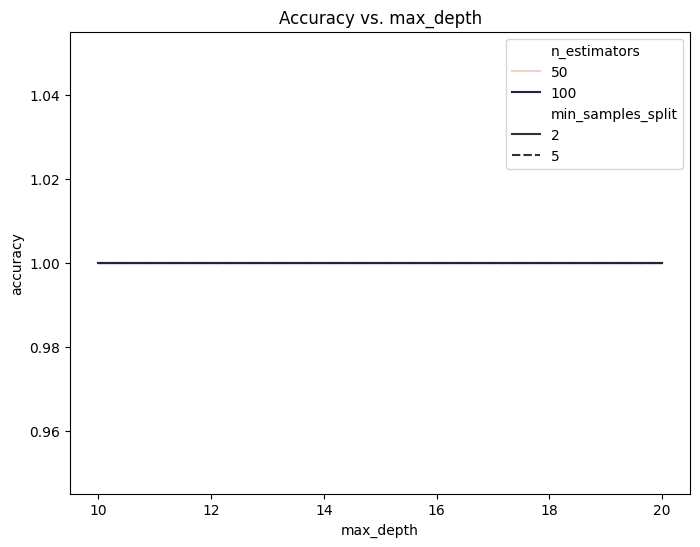

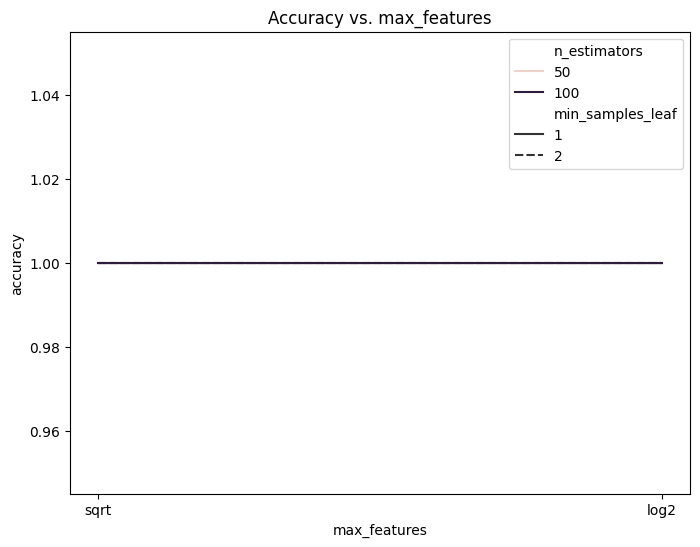

In [6]:
# Cell 6: Main Execution
# Run experiments for different dataset sizes, scaling, imputation strategies, and categorical feature inclusion
for scaling in [True, False]:
    for imputation_strategy in ['mean', 'median']:
        for frac in [0.5, 1.0]:
            for include_categorical in [False, True]:
                print(f"\n=== Experiments: Scaling={scaling}, Imputation={imputation_strategy}, Fraction={frac}, Categorical={include_categorical} ===")
                X_train, X_test, y_train, y_test, le, feature_cols = preprocess_data(
                    df, scaling=scaling, imputation_strategy=imputation_strategy,
                    sample_fraction=frac, include_categorical=include_categorical
                )
                results = run_rf_experiments(X_train, y_train, X_test, y_test, le.classes_, feature_cols)
                visualize_and_save_results(results, X_train, y_train, X_test, y_test, le.classes_, feature_cols)
                results_df = pd.DataFrame(results)
                results_df.to_csv(f"rf_results_mice_scaling_{scaling}_imputation_{imputation_strategy}_frac_{frac}_cat_{include_categorical}.csv", index=False)